<a href="https://colab.research.google.com/github/Saoudyahya/drawing-using-reinforcement-learning-RL-instead-of-pixel-generation/blob/main/stick_man.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

🖥️  Using device: cuda
   GPU: Tesla T4

🧍 STICKMAN DRAWING AI 🧍

🎯 Teaching AI to draw stick figure people!
  Poses: Standing, Waving, Running, Jumping, Sitting, Dancing

🧍🧍🧍🧍🧍🧍🧍🧍🧍🧍🧍🧍🧍🧍🧍🧍🧍🧍🧍🧍🧍🧍🧍🧍🧍🧍🧍🧍🧍🧍🧍🧍🧍🧍🧍
POSE 1/6: BASIC
🧍🧍🧍🧍🧍🧍🧍🧍🧍🧍🧍🧍🧍🧍🧍🧍🧍🧍🧍🧍🧍🧍🧍🧍🧍🧍🧍🧍🧍🧍🧍🧍🧍🧍🧍
  🧍 Stickman has 190 pixels to draw

TRAINING: BASIC STICKMAN 🧍
  🧍 Generating 30 demonstrations for basic pose
  ✓ Avg 81 strokes per stickman
  ✓ Collected 2400 training examples

📝 Learning to draw (40 epochs)
  Epoch   0 | Loss: 3.5493 | Coverage: 32.6%
  Epoch  10 | Loss: 0.6340 | Coverage: 10.0%
  Epoch  20 | Loss: 0.6111 | Coverage: 17.4%
  Epoch  30 | Loss: 0.6058 | Coverage: 23.2%
  Epoch  39 | Loss: 0.5964 | Coverage: 10.0%
✓ Learning complete!

🎨 Practicing (300 episodes)
  Ep    0 | Coverage: 87.4% | Best: 87.4%
  Ep   50 | Coverage: 80.5% | Best: 100.0%
  Ep  100 | Coverage: 54.7% | Best: 100.0%
  Ep  150 | Coverage: 60.5% | Best: 100.0%
  Ep  200 | Coverage: 91.1% | Best: 100.0%
  Ep  250 | Coverage: 90.0% | Best: 10

/tmp/ipython-input-134835756.py:820: UserWarning: Glyph 129485 (\N{STANDING PERSON}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-134835756.py:821: UserWarning: Glyph 129485 (\N{STANDING PERSON}) missing from font(s) DejaVu Sans.
  plt.savefig('/mnt/user-data/outputs/stickman_results.png', dpi=150, bbox_inches='tight')


FileNotFoundError: [Errno 2] No such file or directory: '/mnt/user-data/outputs/stickman_results.png'

/usr/local/lib/python3.12/dist-packages/IPython/core/events.py:89: UserWarning: Glyph 129485 (\N{STANDING PERSON}) missing from font(s) DejaVu Sans.
  func(*args, **kwargs)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 129485 (\N{STANDING PERSON}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


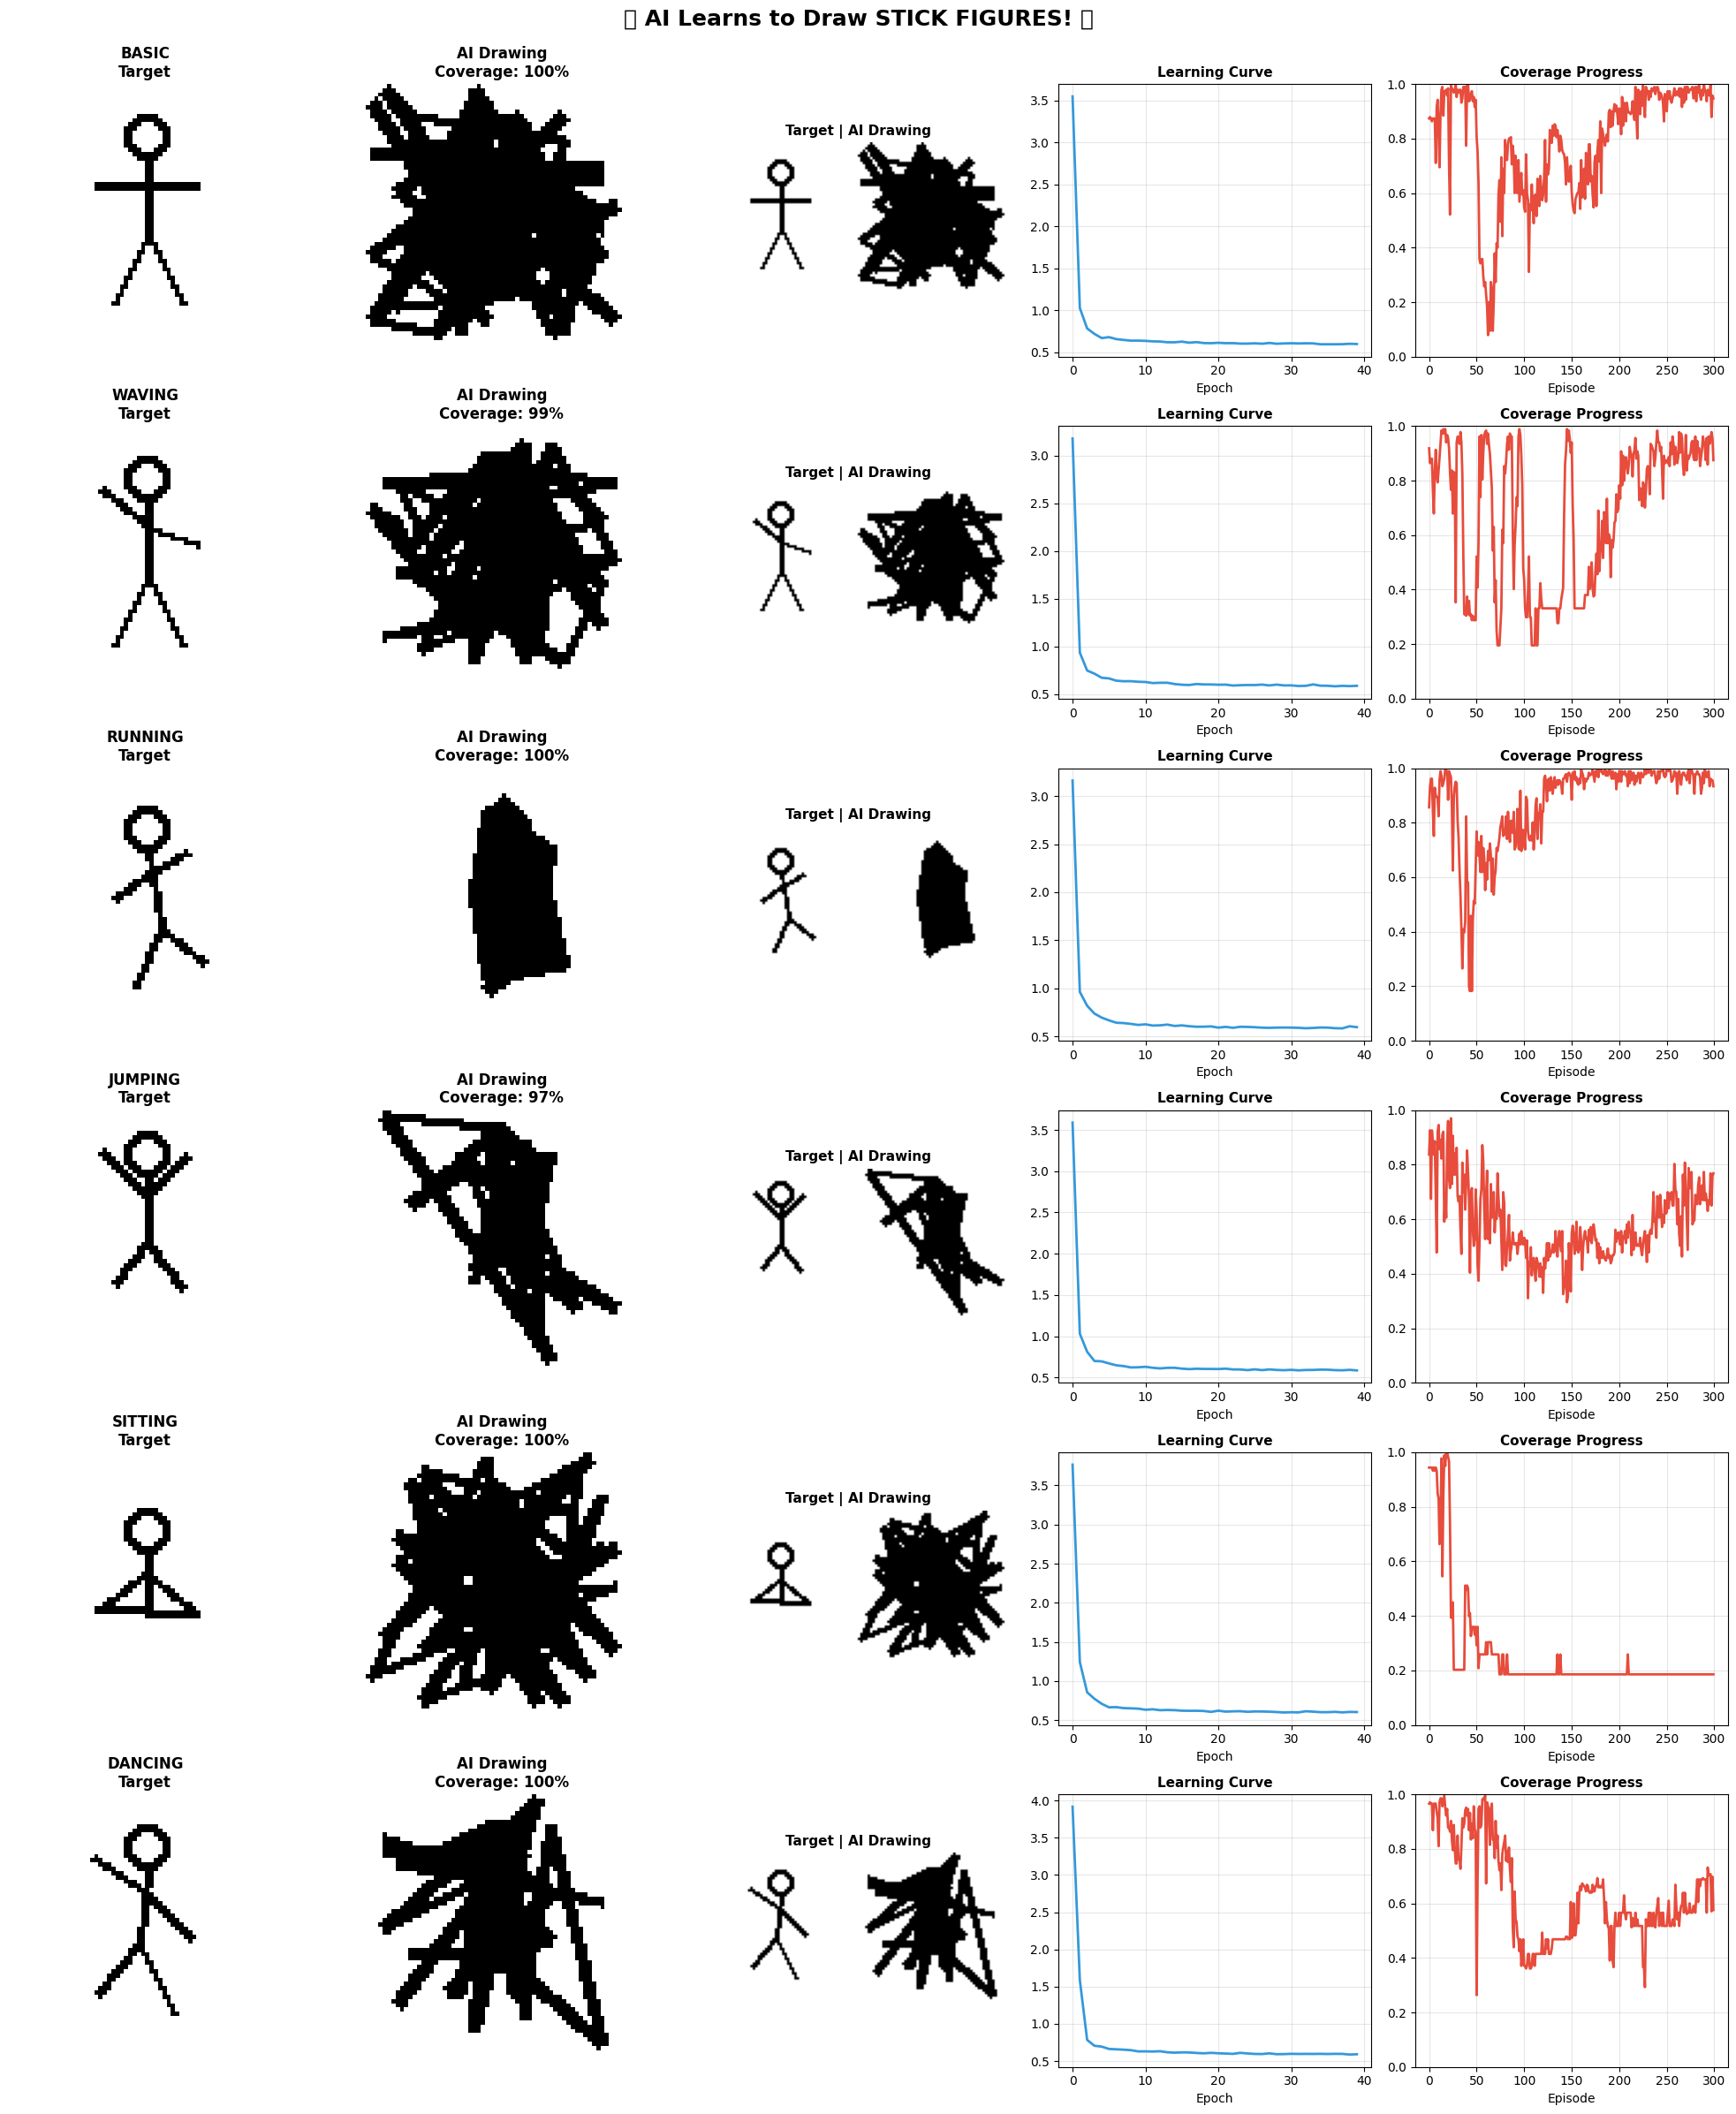

In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw
import torch.nn.functional as F

# GPU Setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"🖥️  Using device: {device}")
if torch.cuda.is_available():
    print(f"   GPU: {torch.cuda.get_device_name(0)}")


class StickmanDrawingEnv:
    """Environment for drawing stick figure people"""
    def __init__(self, canvas_size=64, grid_size=20):
        self.canvas_size = canvas_size
        self.grid_size = grid_size
        self.cell_size = canvas_size // grid_size
        self.target = None
        self.target_mask = None
        self.reset()

    def set_target(self, target):
        """Set target stickman"""
        self.target = target
        self.target_mask = (target[:, :, 0] < 0.5) & (target[:, :, 1] < 0.5) & (target[:, :, 2] < 0.5)
        print(f"  🧍 Stickman has {np.sum(self.target_mask)} pixels to draw")

    def reset(self):
        self.canvas = np.ones((self.canvas_size, self.canvas_size, 3), dtype=np.float32)
        self.cursor_grid_x = self.grid_size // 2
        self.cursor_grid_y = 2  # Start at top (head)
        self.step_count = 0
        self.stroke_history = []
        return self.get_state()

    def compute_coverage(self):
        """How much of the stickman is drawn"""
        if self.target is None:
            return 0.0

        canvas_mask = (self.canvas[:, :, 0] < 0.5) & (self.canvas[:, :, 1] < 0.5) & (self.canvas[:, :, 2] < 0.5)
        coverage = np.sum(self.target_mask & canvas_mask) / max(1, np.sum(self.target_mask))
        return coverage

    def get_state(self):
        """State: canvas + cursor + target"""
        state = np.zeros((self.canvas_size, self.canvas_size, 5), dtype=np.float32)

        # Canvas
        state[:, :, :3] = self.canvas

        # Cursor
        cx = self.cursor_grid_x * self.cell_size + self.cell_size // 2
        cy = self.cursor_grid_y * self.cell_size + self.cell_size // 2
        for dy in range(-4, 5):
            for dx in range(-4, 5):
                if dx*dx + dy*dy <= 16:
                    nx, ny = cx + dx, cy + dy
                    if 0 <= nx < self.canvas_size and 0 <= ny < self.canvas_size:
                        state[ny, nx, 3] = 1.0

        # Target
        if self.target_mask is not None:
            state[:, :, 4] = self.target_mask.astype(np.float32)

        return state

    def grid_to_canvas(self, grid_x, grid_y):
        return grid_x * self.cell_size + self.cell_size // 2, grid_y * self.cell_size + self.cell_size // 2

    def draw_stroke(self, x1, y1, x2, y2):
        """Draw a line segment"""
        img = Image.fromarray((self.canvas * 255).astype(np.uint8))
        draw = ImageDraw.Draw(img)
        draw.line([x1, y1, x2, y2], fill=(0, 0, 0), width=3)
        self.canvas = np.array(img).astype(np.float32) / 255.0

    def step(self, action):
        prev_x, prev_y = self.grid_to_canvas(self.cursor_grid_x, self.cursor_grid_y)
        prev_coverage = self.compute_coverage()

        # Stop action
        if action >= self.grid_size * self.grid_size:
            return self.get_state(), True, {'coverage': prev_coverage, 'progress': 0.0}

        target_grid_x = action % self.grid_size
        target_grid_y = action // self.grid_size

        new_x, new_y = self.grid_to_canvas(target_grid_x, target_grid_y)
        self.draw_stroke(prev_x, prev_y, new_x, new_y)

        self.cursor_grid_x = target_grid_x
        self.cursor_grid_y = target_grid_y
        self.stroke_history.append((prev_x, prev_y, new_x, new_y))
        self.step_count += 1

        curr_coverage = self.compute_coverage()
        done = self.step_count >= 100

        info = {
            'coverage': curr_coverage,
            'progress': curr_coverage - prev_coverage
        }

        return self.get_state(), done, info


class SimpleStickmanNetwork(nn.Module):
    """Network for drawing stickmen"""
    def __init__(self, canvas_size=64, grid_size=20):
        super().__init__()
        self.grid_size = grid_size
        self.num_actions = grid_size * grid_size + 1

        self.conv1 = nn.Conv2d(5, 32, 3, stride=2, padding=1)
        self.conv2 = nn.Conv2d(32, 64, 3, stride=2, padding=1)
        self.conv3 = nn.Conv2d(64, 128, 3, stride=2, padding=1)

        flat_size = 128 * 8 * 8

        self.action_head = nn.Sequential(
            nn.Linear(flat_size, 256),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(256, self.num_actions)
        )

        self.value_head = nn.Sequential(
            nn.Linear(flat_size, 128),
            nn.ReLU(),
            nn.Linear(128, 1)
        )

    def forward(self, state):
        if len(state.shape) == 3:
            state = state.unsqueeze(0)

        state = state.permute(0, 3, 1, 2)

        x = F.relu(self.conv1(state))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))

        features = x.flatten(1)
        action_logits = self.action_head(features)
        value = self.value_head(features)

        return action_logits, value


class StickmanGenerator:
    """Generate stick figure people in different poses"""

    @staticmethod
    def create_basic_stickman(canvas_size=64):
        """Basic standing stickman"""
        img = Image.new('RGB', (canvas_size, canvas_size), 'white')
        draw = ImageDraw.Draw(img)

        center_x = canvas_size // 2

        # Head (circle)
        head_y = 12
        head_radius = 5
        draw.ellipse([center_x - head_radius, head_y - head_radius,
                      center_x + head_radius, head_y + head_radius],
                     outline='black', width=2)

        # Body (vertical line)
        body_top = head_y + head_radius
        body_bottom = body_top + 18
        draw.line([center_x, body_top, center_x, body_bottom], fill='black', width=2)

        # Arms (horizontal line from shoulders)
        shoulder_y = body_top + 6
        arm_span = 12
        draw.line([center_x - arm_span, shoulder_y, center_x + arm_span, shoulder_y],
                  fill='black', width=2)

        # Legs (V shape from body bottom)
        leg_bottom_y = body_bottom + 16
        leg_spread = 8
        draw.line([center_x, body_bottom, center_x - leg_spread, leg_bottom_y],
                  fill='black', width=2)
        draw.line([center_x, body_bottom, center_x + leg_spread, leg_bottom_y],
                  fill='black', width=2)

        return np.array(img).astype(np.float32) / 255.0, "Basic Stickman"

    @staticmethod
    def create_waving_stickman(canvas_size=64):
        """Stickman waving"""
        img = Image.new('RGB', (canvas_size, canvas_size), 'white')
        draw = ImageDraw.Draw(img)

        center_x = canvas_size // 2

        # Head
        head_y = 12
        head_radius = 5
        draw.ellipse([center_x - head_radius, head_y - head_radius,
                      center_x + head_radius, head_y + head_radius],
                     outline='black', width=2)

        # Body
        body_top = head_y + head_radius
        body_bottom = body_top + 18
        draw.line([center_x, body_top, center_x, body_bottom], fill='black', width=2)

        # Left arm (waving up)
        shoulder_y = body_top + 6
        draw.line([center_x, shoulder_y, center_x - 10, shoulder_y - 8], fill='black', width=2)

        # Right arm (down)
        draw.line([center_x, shoulder_y, center_x + 12, shoulder_y + 4], fill='black', width=2)

        # Legs
        leg_bottom_y = body_bottom + 16
        leg_spread = 8
        draw.line([center_x, body_bottom, center_x - leg_spread, leg_bottom_y],
                  fill='black', width=2)
        draw.line([center_x, body_bottom, center_x + leg_spread, leg_bottom_y],
                  fill='black', width=2)

        return np.array(img).astype(np.float32) / 255.0, "Waving Stickman"

    @staticmethod
    def create_running_stickman(canvas_size=64):
        """Stickman running"""
        img = Image.new('RGB', (canvas_size, canvas_size), 'white')
        draw = ImageDraw.Draw(img)

        center_x = canvas_size // 2

        # Head
        head_y = 14
        head_radius = 5
        draw.ellipse([center_x - head_radius, head_y - head_radius,
                      center_x + head_radius, head_y + head_radius],
                     outline='black', width=2)

        # Body (slightly tilted forward)
        body_top = head_y + head_radius
        body_bottom_y = body_top + 18
        body_bottom_x = center_x + 3
        draw.line([center_x, body_top, body_bottom_x, body_bottom_y], fill='black', width=2)

        # Arms (pumping)
        shoulder_y = body_top + 6
        draw.line([center_x, shoulder_y, center_x + 10, shoulder_y - 6], fill='black', width=2)
        draw.line([center_x, shoulder_y, center_x - 8, shoulder_y + 6], fill='black', width=2)

        # Legs (running pose)
        draw.line([body_bottom_x, body_bottom_y, body_bottom_x - 6, body_bottom_y + 14],
                  fill='black', width=2)
        draw.line([body_bottom_x, body_bottom_y, body_bottom_x + 10, body_bottom_y + 8],
                  fill='black', width=2)

        return np.array(img).astype(np.float32) / 255.0, "Running Stickman"

    @staticmethod
    def create_jumping_stickman(canvas_size=64):
        """Stickman jumping"""
        img = Image.new('RGB', (canvas_size, canvas_size), 'white')
        draw = ImageDraw.Draw(img)

        center_x = canvas_size // 2

        # Head (higher up)
        head_y = 10
        head_radius = 5
        draw.ellipse([center_x - head_radius, head_y - head_radius,
                      center_x + head_radius, head_y + head_radius],
                     outline='black', width=2)

        # Body
        body_top = head_y + head_radius
        body_bottom = body_top + 16
        draw.line([center_x, body_top, center_x, body_bottom], fill='black', width=2)

        # Arms (up in the air)
        shoulder_y = body_top + 5
        draw.line([center_x, shoulder_y, center_x - 10, shoulder_y - 10], fill='black', width=2)
        draw.line([center_x, shoulder_y, center_x + 10, shoulder_y - 10], fill='black', width=2)

        # Legs (bent)
        draw.line([center_x, body_bottom, center_x - 8, body_bottom + 10], fill='black', width=2)
        draw.line([center_x, body_bottom, center_x + 8, body_bottom + 10], fill='black', width=2)

        return np.array(img).astype(np.float32) / 255.0, "Jumping Stickman"

    @staticmethod
    def create_sitting_stickman(canvas_size=64):
        """Stickman sitting"""
        img = Image.new('RGB', (canvas_size, canvas_size), 'white')
        draw = ImageDraw.Draw(img)

        center_x = canvas_size // 2

        # Head
        head_y = 18
        head_radius = 5
        draw.ellipse([center_x - head_radius, head_y - head_radius,
                      center_x + head_radius, head_y + head_radius],
                     outline='black', width=2)

        # Body (shorter, sitting)
        body_top = head_y + head_radius
        body_bottom = body_top + 14
        draw.line([center_x, body_top, center_x, body_bottom], fill='black', width=2)

        # Arms (resting)
        shoulder_y = body_top + 5
        draw.line([center_x, shoulder_y, center_x - 10, shoulder_y + 8], fill='black', width=2)
        draw.line([center_x, shoulder_y, center_x + 10, shoulder_y + 8], fill='black', width=2)

        # Legs (bent, sitting)
        draw.line([center_x, body_bottom, center_x - 12, body_bottom], fill='black', width=2)
        draw.line([center_x, body_bottom, center_x + 12, body_bottom], fill='black', width=2)

        return np.array(img).astype(np.float32) / 255.0, "Sitting Stickman"

    @staticmethod
    def create_dancing_stickman(canvas_size=64):
        """Stickman dancing"""
        img = Image.new('RGB', (canvas_size, canvas_size), 'white')
        draw = ImageDraw.Draw(img)

        center_x = canvas_size // 2

        # Head
        head_y = 12
        head_radius = 5
        draw.ellipse([center_x - head_radius, head_y - head_radius,
                      center_x + head_radius, head_y + head_radius],
                     outline='black', width=2)

        # Body (tilted)
        body_top = head_y + head_radius
        body_bottom_y = body_top + 18
        body_bottom_x = center_x - 2
        draw.line([center_x, body_top, body_bottom_x, body_bottom_y], fill='black', width=2)

        # Arms (asymmetric, dancing)
        shoulder_y = body_top + 6
        draw.line([center_x, shoulder_y, center_x - 12, shoulder_y - 8], fill='black', width=2)
        draw.line([center_x, shoulder_y, center_x + 10, shoulder_y + 10], fill='black', width=2)

        # Legs (dynamic pose)
        draw.line([body_bottom_x, body_bottom_y, body_bottom_x - 10, body_bottom_y + 12],
                  fill='black', width=2)
        draw.line([body_bottom_x, body_bottom_y, body_bottom_x + 8, body_bottom_y + 16],
                  fill='black', width=2)

        return np.array(img).astype(np.float32) / 255.0, "Dancing Stickman"


class StickmanExpert:
    """Expert that knows how to draw stick figures"""
    def __init__(self, canvas_size=64, grid_size=20, pose="basic"):
        self.canvas_size = canvas_size
        self.grid_size = grid_size
        self.cell_size = canvas_size // grid_size
        self.pose = pose

    def canvas_to_grid(self, x, y):
        grid_x = int(x / self.cell_size)
        grid_y = int(y / self.cell_size)
        return np.clip(grid_x, 0, self.grid_size - 1), np.clip(grid_y, 0, self.grid_size - 1)

    def draw_circle(self, center_x, center_y, radius, num_points=20):
        """Helper to draw a circle"""
        points = []
        for i in range(num_points):
            angle = 2 * np.pi * i / num_points
            x = center_x + radius * np.cos(angle)
            y = center_y + radius * np.sin(angle)
            points.append(self.canvas_to_grid(x, y))
        return points

    def draw_line(self, x1, y1, x2, y2, num_points=15):
        """Helper to draw a line"""
        points = []
        for i in range(num_points):
            t = i / (num_points - 1)
            x = x1 + (x2 - x1) * t
            y = y1 + (y2 - y1) * t
            points.append(self.canvas_to_grid(x, y))
        return points

    def generate_basic_demo(self):
        """Demo for basic standing stickman"""
        center_x = self.canvas_size // 2
        trajectory = []

        # 1. Draw head (circle)
        head_y = 12
        trajectory.extend(self.draw_circle(center_x, head_y, 5))

        # 2. Draw body (top to bottom)
        body_top = head_y + 5
        body_bottom = body_top + 18
        trajectory.extend(self.draw_line(center_x, body_top, center_x, body_bottom))

        # 3. Draw arms (left to right)
        shoulder_y = body_top + 6
        trajectory.extend(self.draw_line(center_x - 12, shoulder_y, center_x + 12, shoulder_y))

        # 4. Draw left leg
        trajectory.extend(self.draw_line(center_x, body_bottom, center_x - 8, body_bottom + 16))

        # 5. Draw right leg
        trajectory.extend(self.draw_line(center_x, body_bottom, center_x + 8, body_bottom + 16))

        return trajectory

    def generate_waving_demo(self):
        """Demo for waving stickman"""
        center_x = self.canvas_size // 2
        trajectory = []

        # Head
        head_y = 12
        trajectory.extend(self.draw_circle(center_x, head_y, 5))

        # Body
        body_top = head_y + 5
        body_bottom = body_top + 18
        trajectory.extend(self.draw_line(center_x, body_top, center_x, body_bottom))

        # Left arm (waving up)
        shoulder_y = body_top + 6
        trajectory.extend(self.draw_line(center_x, shoulder_y, center_x - 10, shoulder_y - 8))

        # Right arm (down)
        trajectory.extend(self.draw_line(center_x, shoulder_y, center_x + 12, shoulder_y + 4))

        # Legs
        trajectory.extend(self.draw_line(center_x, body_bottom, center_x - 8, body_bottom + 16))
        trajectory.extend(self.draw_line(center_x, body_bottom, center_x + 8, body_bottom + 16))

        return trajectory

    def generate_running_demo(self):
        """Demo for running stickman"""
        center_x = self.canvas_size // 2
        trajectory = []

        # Head
        head_y = 14
        trajectory.extend(self.draw_circle(center_x, head_y, 5))

        # Body (tilted)
        body_top = head_y + 5
        body_bottom_y = body_top + 18
        body_bottom_x = center_x + 3
        trajectory.extend(self.draw_line(center_x, body_top, body_bottom_x, body_bottom_y))

        # Arms
        shoulder_y = body_top + 6
        trajectory.extend(self.draw_line(center_x, shoulder_y, center_x + 10, shoulder_y - 6))
        trajectory.extend(self.draw_line(center_x, shoulder_y, center_x - 8, shoulder_y + 6))

        # Legs
        trajectory.extend(self.draw_line(body_bottom_x, body_bottom_y,
                                        body_bottom_x - 6, body_bottom_y + 14))
        trajectory.extend(self.draw_line(body_bottom_x, body_bottom_y,
                                        body_bottom_x + 10, body_bottom_y + 8))

        return trajectory

    def generate_jumping_demo(self):
        """Demo for jumping stickman"""
        center_x = self.canvas_size // 2
        trajectory = []

        # Head
        head_y = 10
        trajectory.extend(self.draw_circle(center_x, head_y, 5))

        # Body
        body_top = head_y + 5
        body_bottom = body_top + 16
        trajectory.extend(self.draw_line(center_x, body_top, center_x, body_bottom))

        # Arms (up)
        shoulder_y = body_top + 5
        trajectory.extend(self.draw_line(center_x, shoulder_y, center_x - 10, shoulder_y - 10))
        trajectory.extend(self.draw_line(center_x, shoulder_y, center_x + 10, shoulder_y - 10))

        # Legs
        trajectory.extend(self.draw_line(center_x, body_bottom, center_x - 8, body_bottom + 10))
        trajectory.extend(self.draw_line(center_x, body_bottom, center_x + 8, body_bottom + 10))

        return trajectory

    def generate_sitting_demo(self):
        """Demo for sitting stickman"""
        center_x = self.canvas_size // 2
        trajectory = []

        # Head
        head_y = 18
        trajectory.extend(self.draw_circle(center_x, head_y, 5))

        # Body
        body_top = head_y + 5
        body_bottom = body_top + 14
        trajectory.extend(self.draw_line(center_x, body_top, center_x, body_bottom))

        # Arms
        shoulder_y = body_top + 5
        trajectory.extend(self.draw_line(center_x, shoulder_y, center_x - 10, shoulder_y + 8))
        trajectory.extend(self.draw_line(center_x, shoulder_y, center_x + 10, shoulder_y + 8))

        # Legs (horizontal, sitting)
        trajectory.extend(self.draw_line(center_x, body_bottom, center_x - 12, body_bottom))
        trajectory.extend(self.draw_line(center_x, body_bottom, center_x + 12, body_bottom))

        return trajectory

    def generate_dancing_demo(self):
        """Demo for dancing stickman"""
        center_x = self.canvas_size // 2
        trajectory = []

        # Head
        head_y = 12
        trajectory.extend(self.draw_circle(center_x, head_y, 5))

        # Body (tilted)
        body_top = head_y + 5
        body_bottom_y = body_top + 18
        body_bottom_x = center_x - 2
        trajectory.extend(self.draw_line(center_x, body_top, body_bottom_x, body_bottom_y))

        # Arms (asymmetric)
        shoulder_y = body_top + 6
        trajectory.extend(self.draw_line(center_x, shoulder_y, center_x - 12, shoulder_y - 8))
        trajectory.extend(self.draw_line(center_x, shoulder_y, center_x + 10, shoulder_y + 10))

        # Legs
        trajectory.extend(self.draw_line(body_bottom_x, body_bottom_y,
                                        body_bottom_x - 10, body_bottom_y + 12))
        trajectory.extend(self.draw_line(body_bottom_x, body_bottom_y,
                                        body_bottom_x + 8, body_bottom_y + 16))

        return trajectory

    def _to_actions(self, trajectory):
        actions = [grid_y * self.grid_size + grid_x for grid_x, grid_y in trajectory]
        actions.append(self.grid_size * self.grid_size)
        return actions

    def generate_demonstration(self):
        demos = {
            "basic": self.generate_basic_demo,
            "waving": self.generate_waving_demo,
            "running": self.generate_running_demo,
            "jumping": self.generate_jumping_demo,
            "sitting": self.generate_sitting_demo,
            "dancing": self.generate_dancing_demo
        }
        trajectory = demos[self.pose]()
        return self._to_actions(trajectory)

    def generate_demonstrations(self, num_demos):
        print(f"  🧍 Generating {num_demos} demonstrations for {self.pose} pose")
        all_demos = [self.generate_demonstration() for _ in range(num_demos)]
        print(f"  ✓ Avg {np.mean([len(d) for d in all_demos]):.0f} strokes per stickman")
        return all_demos


class StickmanTrainer:
    """Train agent to draw stick figures"""
    def __init__(self, target_image, pose_name, canvas_size=64, grid_size=20, device='cpu'):
        self.device = torch.device(device)
        self.env = StickmanDrawingEnv(canvas_size, grid_size)
        self.policy = SimpleStickmanNetwork(canvas_size, grid_size).to(self.device)
        self.optimizer = optim.Adam(self.policy.parameters(), lr=2e-3)
        self.pose_name = pose_name

        self.target = target_image
        self.env.set_target(self.target)
        self.expert = StickmanExpert(canvas_size, grid_size, pose_name)

        self.best_coverage = 0.0
        self.best_canvas = None
        self.coverage_history = []
        self.bc_losses = []

    def collect_expert_data(self):
        demos = self.expert.generate_demonstrations(30)
        states, actions = [], []

        for demo in demos:
            state = self.env.reset()
            for action in demo[:-1]:
                states.append(state)
                actions.append(action)
                state, _, _ = self.env.step(action)

        print(f"  ✓ Collected {len(states)} training examples")
        return states, actions

    def behavioral_cloning(self, states, actions, batch_size=64):
        epochs = 40
        print(f"\n📝 Learning to draw ({epochs} epochs)")
        print("="*70)

        dataset_size = len(states)

        for epoch in range(epochs):
            total_loss, num_batches = 0, 0
            indices = list(range(dataset_size))
            np.random.shuffle(indices)

            for i in range(0, dataset_size, batch_size):
                batch_idx = indices[i:i+batch_size]
                batch_states = torch.FloatTensor(np.array([states[idx] for idx in batch_idx])).to(self.device)
                batch_actions = torch.LongTensor(np.array([actions[idx] for idx in batch_idx])).to(self.device)

                action_logits, _ = self.policy(batch_states)
                loss = F.cross_entropy(action_logits, batch_actions)

                self.optimizer.zero_grad()
                loss.backward()
                self.optimizer.step()

                total_loss += loss.item()
                num_batches += 1

            avg_loss = total_loss / num_batches
            self.bc_losses.append(avg_loss)

            if epoch % 10 == 0 or epoch == epochs - 1:
                coverage = self.test_policy()
                print(f"  Epoch {epoch:3d} | Loss: {avg_loss:.4f} | Coverage: {coverage:.1%}")

        print("✓ Learning complete!\n")

    def test_policy(self):
        state = self.env.reset()
        done = False

        with torch.no_grad():
            while not done:
                state_tensor = torch.FloatTensor(state).to(self.device)
                action_logits, _ = self.policy(state_tensor)
                action = torch.argmax(action_logits).item()
                state, done, info = self.env.step(action)

        coverage = info['coverage']
        if coverage > self.best_coverage:
            self.best_coverage = coverage
            self.best_canvas = self.env.canvas.copy()

        return coverage

    def rl_practice(self):
        episodes = 300
        print(f"🎨 Practicing ({episodes} episodes)")
        print("="*70)

        for episode in range(episodes):
            state = self.env.reset()
            states, actions, rewards, log_probs, values = [], [], [], [], []
            done = False

            while not done:
                state_tensor = torch.FloatTensor(state).to(self.device)
                action_logits, value = self.policy(state_tensor)

                action_dist = torch.distributions.Categorical(logits=action_logits)
                action = action_dist.sample()
                log_prob = action_dist.log_prob(action)

                next_state, done, info = self.env.step(action.item())
                reward = info['progress'] * 150

                states.append(state)
                actions.append(action)
                rewards.append(reward)
                log_probs.append(log_prob)
                values.append(value)

                state = next_state

            # Returns
            returns = []
            G = 0
            for r in reversed(rewards):
                G = r + 0.99 * G
                returns.insert(0, G)

            returns = torch.FloatTensor(returns).to(self.device)
            if len(returns) > 1:
                returns = (returns - returns.mean()) / (returns.std() + 1e-8)

            # Update
            policy_loss, value_loss = 0, 0
            for log_prob, value, ret in zip(log_probs, values, returns):
                advantage = ret - value.squeeze().detach()
                policy_loss = policy_loss - log_prob * advantage
                value_loss = value_loss + F.mse_loss(value.squeeze(), ret)

            loss = policy_loss / len(log_probs) + 0.5 * value_loss / len(values)

            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()

            final_coverage = info['coverage']
            self.coverage_history.append(final_coverage)

            if final_coverage > self.best_coverage:
                self.best_coverage = final_coverage
                self.best_canvas = self.env.canvas.copy()

            if episode % 50 == 0 or episode == episodes - 1:
                print(f"  Ep {episode:4d} | Coverage: {final_coverage:5.1%} | Best: {self.best_coverage:5.1%}")

        print("✓ Practice complete!\n")

    def train(self):
        print("\n" + "="*70)
        print(f"TRAINING: {self.pose_name.upper()} STICKMAN 🧍")
        print("="*70)

        states, actions = self.collect_expert_data()
        self.behavioral_cloning(states, actions)
        self.rl_practice()

        return self.best_canvas


def train_all_poses(canvas_size=64, grid_size=20, device='cpu'):
    """Train stickman drawing for all poses"""
    poses = [
        ("basic", StickmanGenerator.create_basic_stickman),
        ("waving", StickmanGenerator.create_waving_stickman),
        ("running", StickmanGenerator.create_running_stickman),
        ("jumping", StickmanGenerator.create_jumping_stickman),
        ("sitting", StickmanGenerator.create_sitting_stickman),
        ("dancing", StickmanGenerator.create_dancing_stickman),
    ]

    results = []

    for idx, (pose_name, pose_func) in enumerate(poses):
        print("\n" + "🧍"*35)
        print(f"POSE {idx+1}/6: {pose_name.upper()}")
        print("🧍"*35)

        target, _ = pose_func(canvas_size)
        trainer = StickmanTrainer(target, pose_name, canvas_size, grid_size, device)
        final_canvas = trainer.train()

        results.append({
            'name': pose_name,
            'target': target,
            'canvas': final_canvas,
            'coverage': trainer.best_coverage,
            'coverage_history': trainer.coverage_history,
            'bc_losses': trainer.bc_losses
        })

    return results


def visualize_results(results):
    """Show stickman results"""
    n = len(results)
    fig = plt.figure(figsize=(20, 4*n))

    for idx, r in enumerate(results):
        # Target
        ax = plt.subplot(n, 5, idx*5 + 1)
        ax.imshow(r['target'])
        ax.set_title(f"{r['name'].upper()}\nTarget", fontsize=12, fontweight='bold')
        ax.axis('off')

        # AI Drawing
        ax = plt.subplot(n, 5, idx*5 + 2)
        ax.imshow(r['canvas'])
        ax.set_title(f"AI Drawing\nCoverage: {r['coverage']:.0%}",
                    fontsize=12, fontweight='bold')
        ax.axis('off')

        # Comparison
        ax = plt.subplot(n, 5, idx*5 + 3)
        comparison = np.concatenate([r['target'], r['canvas']], axis=1)
        ax.imshow(comparison)
        ax.set_title('Target | AI Drawing', fontsize=11, fontweight='bold')
        ax.axis('off')

        # BC Loss
        ax = plt.subplot(n, 5, idx*5 + 4)
        if r['bc_losses']:
            ax.plot(r['bc_losses'], linewidth=2, color='#3498db')
            ax.set_title('Learning Curve', fontsize=11, fontweight='bold')
            ax.grid(True, alpha=0.3)
            ax.set_xlabel('Epoch')

        # Coverage
        ax = plt.subplot(n, 5, idx*5 + 5)
        if r['coverage_history']:
            ax.plot(r['coverage_history'], linewidth=2, color='#e74c3c')
            ax.set_title('Coverage Progress', fontsize=11, fontweight='bold')
            ax.set_ylim([0, 1])
            ax.grid(True, alpha=0.3)
            ax.set_xlabel('Episode')

    plt.suptitle("🧍 AI Learns to Draw STICK FIGURES! 🧍",
                fontsize=18, y=0.995, fontweight='bold')
    plt.tight_layout()
    plt.savefig('/mnt/user-data/outputs/stickman_results.png', dpi=150, bbox_inches='tight')
    print(f"\n✅ Saved: /mnt/user-data/outputs/stickman_results.png")


# MAIN
if __name__ == "__main__":
    print("\n" + "="*70)
    print("🧍 STICKMAN DRAWING AI 🧍")
    print("="*70)
    print("\n🎯 Teaching AI to draw stick figure people!")
    print("  Poses: Standing, Waving, Running, Jumping, Sitting, Dancing")
    print("="*70)

    results = train_all_poses(canvas_size=64, grid_size=20, device=device)
    visualize_results(results)

    print("\n" + "="*70)
    print("✅ STICKMAN TRAINING COMPLETE!")
    print("="*70)
    print(f"{'Pose':15} {'Coverage':10}")
    print("-"*70)
    for r in results:
        print(f"{r['name'].upper():15} {r['coverage']:9.1%}")
    print("="*70)
    print("\n🎉 AI can now draw stick figures! 🧍")
    print("="*70 + "\n")

    plt.show()

🖥️  Using device: cuda
   GPU: Tesla T4

🧍 IMPROVED STICKMAN DRAWING AI 🧍

🧍🧍🧍🧍🧍🧍🧍🧍🧍🧍🧍🧍🧍🧍🧍🧍🧍🧍🧍🧍🧍🧍🧍🧍🧍🧍🧍🧍🧍🧍🧍🧍🧍🧍🧍
POSE 1/3: BASIC
🧍🧍🧍🧍🧍🧍🧍🧍🧍🧍🧍🧍🧍🧍🧍🧍🧍🧍🧍🧍🧍🧍🧍🧍🧍🧍🧍🧍🧍🧍🧍🧍🧍🧍🧍
  🧍 Target has 190 pixels

🎨 Training basic stickman (500 episodes)
  Ep    0 | Cov: 57.4% | Prec:  7.0% | Best: 57.4% | ε: 1.00
  Ep   50 | Cov: 91.1% | Prec:  8.1% | Best: 95.8% | ε: 0.75
  Ep  100 | Cov: 82.1% | Prec:  8.1% | Best: 95.8% | ε: 0.50
  Ep  150 | Cov: 68.9% | Prec:  6.1% | Best: 96.8% | ε: 0.25
  Ep  200 | Cov: 72.6% | Prec:  7.3% | Best: 96.8% | ε: 0.05
  Ep  250 | Cov: 73.2% | Prec:  8.7% | Best: 92.6% | ε: 0.05
  Ep  300 | Cov: 74.7% | Prec:  8.2% | Best: 86.3% | ε: 0.05
  Ep  350 | Cov: 71.6% | Prec:  7.7% | Best: 92.6% | ε: 0.05
  Ep  400 | Cov: 86.8% | Prec:  8.6% | Best: 88.9% | ε: 0.05
  Ep  450 | Cov: 77.9% | Prec:  8.6% | Best: 88.4% | ε: 0.05
  Ep  499 | Cov: 73.7% | Prec:  8.1% | Best: 99.5% | ε: 0.05
✓ Training complete! Best coverage: 99.5%, Precision: 9.3%


🧍🧍🧍🧍🧍🧍🧍🧍🧍🧍🧍🧍🧍🧍🧍🧍🧍🧍🧍🧍🧍🧍🧍🧍🧍🧍🧍🧍🧍🧍🧍🧍🧍🧍🧍
P

/tmp/ipython-input-1006318776.py:504: UserWarning: Glyph 129485 (\N{STANDING PERSON}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-1006318776.py:505: UserWarning: Glyph 129485 (\N{STANDING PERSON}) missing from font(s) DejaVu Sans.
  plt.savefig('/mnt/user-data/outputs/improved_stickman_results.png', dpi=150, bbox_inches='tight')


FileNotFoundError: [Errno 2] No such file or directory: '/mnt/user-data/outputs/improved_stickman_results.png'

/usr/local/lib/python3.12/dist-packages/IPython/core/events.py:89: UserWarning: Glyph 129485 (\N{STANDING PERSON}) missing from font(s) DejaVu Sans.
  func(*args, **kwargs)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 129485 (\N{STANDING PERSON}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


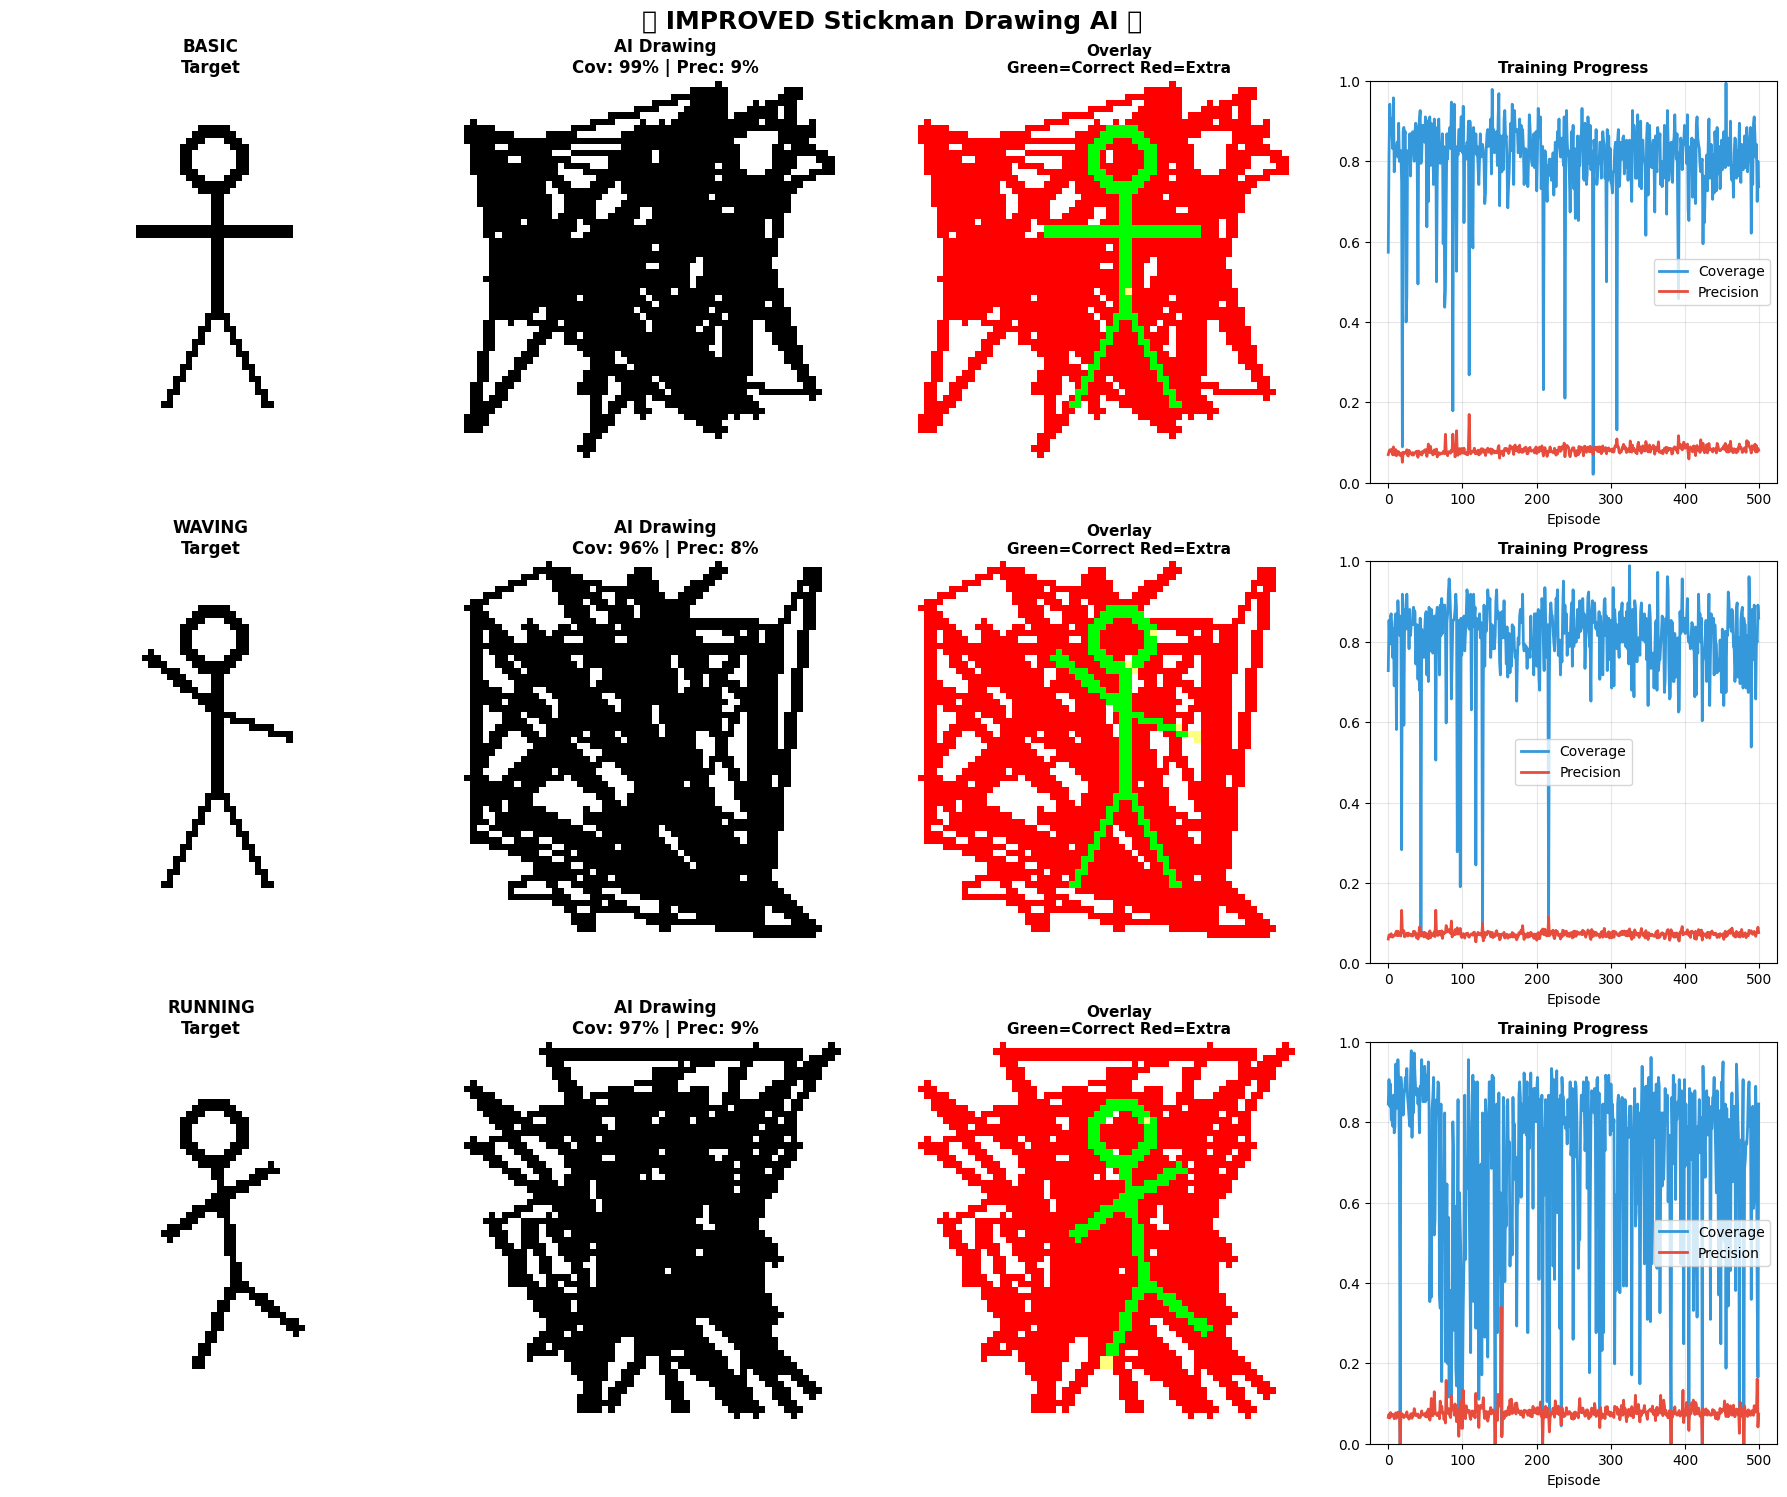

In [6]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw
import torch.nn.functional as F

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"🖥️  Using device: {device}")
if torch.cuda.is_available():
    print(f"   GPU: {torch.cuda.get_device_name(0)}")


class ImprovedStickmanEnv:
    """Improved environment with better reward shaping"""
    def __init__(self, canvas_size=64, grid_size=20):
        self.canvas_size = canvas_size
        self.grid_size = grid_size
        self.cell_size = canvas_size // grid_size
        self.target = None
        self.target_mask = None
        self.drawn_pixels = set()
        self.reset()

    def set_target(self, target):
        self.target = target
        self.target_mask = (target[:, :, 0] < 0.5) & (target[:, :, 1] < 0.5) & (target[:, :, 2] < 0.5)
        self.target_pixels = set(zip(*np.where(self.target_mask)))
        print(f"  🧍 Target has {len(self.target_pixels)} pixels")

    def reset(self):
        self.canvas = np.ones((self.canvas_size, self.canvas_size, 3), dtype=np.float32)
        self.cursor_grid_x = self.grid_size // 2
        self.cursor_grid_y = 2
        self.step_count = 0
        self.stroke_history = []
        self.drawn_pixels = set()
        self.last_coverage = 0.0
        return self.get_state()

    def compute_metrics(self):
        """Compute coverage and penalties"""
        canvas_mask = (self.canvas[:, :, 0] < 0.5) & (self.canvas[:, :, 1] < 0.5) & (self.canvas[:, :, 2] < 0.5)
        canvas_pixels = set(zip(*np.where(canvas_mask)))

        # True positives: pixels correctly drawn
        correct_pixels = canvas_pixels & self.target_pixels

        # False positives: pixels drawn outside target
        extra_pixels = canvas_pixels - self.target_pixels

        # Coverage
        coverage = len(correct_pixels) / max(1, len(self.target_pixels))

        # Precision (how much of what we drew is correct)
        precision = len(correct_pixels) / max(1, len(canvas_pixels))

        return coverage, precision, len(extra_pixels)

    def get_state(self):
        state = np.zeros((self.canvas_size, self.canvas_size, 6), dtype=np.float32)

        # Canvas
        state[:, :, :3] = self.canvas

        # Cursor
        cx = self.cursor_grid_x * self.cell_size + self.cell_size // 2
        cy = self.cursor_grid_y * self.cell_size + self.cell_size // 2
        for dy in range(-3, 4):
            for dx in range(-3, 4):
                if dx*dx + dy*dy <= 9:
                    nx, ny = cx + dx, cy + dy
                    if 0 <= nx < self.canvas_size and 0 <= ny < self.canvas_size:
                        state[ny, nx, 3] = 1.0

        # Target
        if self.target_mask is not None:
            state[:, :, 4] = self.target_mask.astype(np.float32)

        # Previous coverage as context
        state[:, :, 5] = self.last_coverage

        return state

    def grid_to_canvas(self, grid_x, grid_y):
        return grid_x * self.cell_size + self.cell_size // 2, grid_y * self.cell_size + self.cell_size // 2

    def draw_stroke(self, x1, y1, x2, y2):
        img = Image.fromarray((self.canvas * 255).astype(np.uint8))
        draw = ImageDraw.Draw(img)
        draw.line([x1, y1, x2, y2], fill=(0, 0, 0), width=2)  # Thinner lines
        self.canvas = np.array(img).astype(np.float32) / 255.0

    def step(self, action):
        prev_x, prev_y = self.grid_to_canvas(self.cursor_grid_x, self.cursor_grid_y)
        prev_coverage, prev_precision, prev_extra = self.compute_metrics()

        # Stop action
        if action >= self.grid_size * self.grid_size:
            coverage, precision, extra = self.compute_metrics()
            # Bonus for finishing with good coverage and precision
            final_reward = coverage * 50 + precision * 20
            return self.get_state(), True, {
                'coverage': coverage,
                'precision': precision,
                'reward': final_reward
            }

        target_grid_x = action % self.grid_size
        target_grid_y = action // self.grid_size

        new_x, new_y = self.grid_to_canvas(target_grid_x, target_grid_y)
        self.draw_stroke(prev_x, prev_y, new_x, new_y)

        self.cursor_grid_x = target_grid_x
        self.cursor_grid_y = target_grid_y
        self.stroke_history.append((prev_x, prev_y, new_x, new_y))
        self.step_count += 1

        # Compute new metrics
        coverage, precision, extra = self.compute_metrics()

        # IMPROVED REWARD SHAPING
        # 1. Reward for increasing coverage
        coverage_gain = (coverage - prev_coverage) * 200

        # 2. Penalty for drawing outside target (reduced precision)
        precision_penalty = (prev_precision - precision) * 50

        # 3. Small penalty for each stroke (encourage efficiency)
        efficiency_penalty = -0.5

        # 4. Bonus for maintaining high precision
        precision_bonus = precision * 2 if precision > 0.8 else 0

        reward = coverage_gain + precision_bonus + efficiency_penalty + precision_penalty

        self.last_coverage = coverage
        done = self.step_count >= 80  # Reduced max steps

        info = {
            'coverage': coverage,
            'precision': precision,
            'reward': reward,
            'extra_pixels': extra
        }

        return self.get_state(), done, info


class ImprovedStickmanNetwork(nn.Module):
    """Improved network with better architecture"""
    def __init__(self, canvas_size=64, grid_size=20):
        super().__init__()
        self.grid_size = grid_size
        self.num_actions = grid_size * grid_size + 1

        # Better CNN architecture
        self.conv1 = nn.Conv2d(6, 32, 3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, 3, stride=2, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(64, 128, 3, stride=2, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.conv4 = nn.Conv2d(128, 256, 3, stride=2, padding=1)
        self.bn4 = nn.BatchNorm2d(256)

        flat_size = 256 * 8 * 8

        self.action_head = nn.Sequential(
            nn.Linear(flat_size, 512),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(256, self.num_actions)
        )

        self.value_head = nn.Sequential(
            nn.Linear(flat_size, 256),
            nn.ReLU(),
            nn.Linear(256, 1)
        )

    def forward(self, state):
        if len(state.shape) == 3:
            state = state.unsqueeze(0)

        state = state.permute(0, 3, 1, 2)

        x = F.relu(self.bn1(self.conv1(state)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.relu(self.bn3(self.conv3(x)))
        x = F.relu(self.bn4(self.conv4(x)))

        features = x.flatten(1)
        action_logits = self.action_head(features)
        value = self.value_head(features)

        return action_logits, value


class StickmanGenerator:
    """Generate stick figures (same as before)"""

    @staticmethod
    def create_basic_stickman(canvas_size=64):
        img = Image.new('RGB', (canvas_size, canvas_size), 'white')
        draw = ImageDraw.Draw(img)
        center_x = canvas_size // 2

        head_y = 12
        head_radius = 5
        draw.ellipse([center_x - head_radius, head_y - head_radius,
                      center_x + head_radius, head_y + head_radius],
                     outline='black', width=2)

        body_top = head_y + head_radius
        body_bottom = body_top + 18
        draw.line([center_x, body_top, center_x, body_bottom], fill='black', width=2)

        shoulder_y = body_top + 6
        arm_span = 12
        draw.line([center_x - arm_span, shoulder_y, center_x + arm_span, shoulder_y],
                  fill='black', width=2)

        leg_bottom_y = body_bottom + 16
        leg_spread = 8
        draw.line([center_x, body_bottom, center_x - leg_spread, leg_bottom_y],
                  fill='black', width=2)
        draw.line([center_x, body_bottom, center_x + leg_spread, leg_bottom_y],
                  fill='black', width=2)

        return np.array(img).astype(np.float32) / 255.0, "Basic"

    @staticmethod
    def create_waving_stickman(canvas_size=64):
        img = Image.new('RGB', (canvas_size, canvas_size), 'white')
        draw = ImageDraw.Draw(img)
        center_x = canvas_size // 2

        head_y = 12
        head_radius = 5
        draw.ellipse([center_x - head_radius, head_y - head_radius,
                      center_x + head_radius, head_y + head_radius],
                     outline='black', width=2)

        body_top = head_y + head_radius
        body_bottom = body_top + 18
        draw.line([center_x, body_top, center_x, body_bottom], fill='black', width=2)

        shoulder_y = body_top + 6
        draw.line([center_x, shoulder_y, center_x - 10, shoulder_y - 8], fill='black', width=2)
        draw.line([center_x, shoulder_y, center_x + 12, shoulder_y + 4], fill='black', width=2)

        leg_bottom_y = body_bottom + 16
        leg_spread = 8
        draw.line([center_x, body_bottom, center_x - leg_spread, leg_bottom_y],
                  fill='black', width=2)
        draw.line([center_x, body_bottom, center_x + leg_spread, leg_bottom_y],
                  fill='black', width=2)

        return np.array(img).astype(np.float32) / 255.0, "Waving"

    @staticmethod
    def create_running_stickman(canvas_size=64):
        img = Image.new('RGB', (canvas_size, canvas_size), 'white')
        draw = ImageDraw.Draw(img)
        center_x = canvas_size // 2

        head_y = 14
        head_radius = 5
        draw.ellipse([center_x - head_radius, head_y - head_radius,
                      center_x + head_radius, head_y + head_radius],
                     outline='black', width=2)

        body_top = head_y + head_radius
        body_bottom_y = body_top + 18
        body_bottom_x = center_x + 3
        draw.line([center_x, body_top, body_bottom_x, body_bottom_y], fill='black', width=2)

        shoulder_y = body_top + 6
        draw.line([center_x, shoulder_y, center_x + 10, shoulder_y - 6], fill='black', width=2)
        draw.line([center_x, shoulder_y, center_x - 8, shoulder_y + 6], fill='black', width=2)

        draw.line([body_bottom_x, body_bottom_y, body_bottom_x - 6, body_bottom_y + 14],
                  fill='black', width=2)
        draw.line([body_bottom_x, body_bottom_y, body_bottom_x + 10, body_bottom_y + 8],
                  fill='black', width=2)

        return np.array(img).astype(np.float32) / 255.0, "Running"


class ImprovedStickmanTrainer:
    """Improved trainer with better learning"""
    def __init__(self, target_image, pose_name, canvas_size=64, grid_size=20, device='cpu'):
        self.device = torch.device(device)
        self.env = ImprovedStickmanEnv(canvas_size, grid_size)
        self.policy = ImprovedStickmanNetwork(canvas_size, grid_size).to(self.device)
        self.optimizer = optim.Adam(self.policy.parameters(), lr=1e-3)
        self.pose_name = pose_name

        self.target = target_image
        self.env.set_target(self.target)

        self.best_coverage = 0.0
        self.best_precision = 0.0
        self.best_canvas = None
        self.coverage_history = []
        self.precision_history = []

    def train_with_mixed_approach(self):
        """Mix of imitation + RL with better exploration"""
        episodes = 500
        print(f"\n🎨 Training {self.pose_name} stickman ({episodes} episodes)")
        print("="*70)

        # Start with high exploration, gradually reduce
        for episode in range(episodes):
            state = self.env.reset()
            states, actions, rewards, log_probs, values = [], [], [], [], []
            done = False
            epsilon = max(0.05, 1.0 - episode / 200)  # Decay exploration

            while not done:
                state_tensor = torch.FloatTensor(state).to(self.device)

                with torch.no_grad():
                    action_logits, value = self.policy(state_tensor)

                # Epsilon-greedy with temperature
                if np.random.random() < epsilon:
                    # Explore: sample from distribution
                    temp = max(0.5, 2.0 - episode / 150)
                    action_dist = torch.distributions.Categorical(logits=action_logits / temp)
                    action = action_dist.sample()
                else:
                    # Exploit: take best action
                    action = torch.argmax(action_logits)

                action_dist = torch.distributions.Categorical(logits=action_logits)
                log_prob = action_dist.log_prob(action)

                next_state, done, info = self.env.step(action.item())
                reward = info['reward']

                states.append(state)
                actions.append(action)
                rewards.append(reward)
                log_probs.append(log_prob)
                values.append(value)

                state = next_state

            # Compute returns with GAE
            returns = []
            advantages = []
            G = 0
            A = 0
            gamma = 0.99
            lam = 0.95

            for r, v in zip(reversed(rewards), reversed(values)):
                G = r + gamma * G
                returns.insert(0, G)
                delta = r + gamma * G - v.item()
                A = delta + gamma * lam * A
                advantages.insert(0, A)

            returns = torch.FloatTensor(returns).to(self.device)
            advantages = torch.FloatTensor(advantages).to(self.device)

            if len(returns) > 1:
                returns = (returns - returns.mean()) / (returns.std() + 1e-8)
                advantages = (advantages - advantages.mean()) / (advantages.std() + 1e-8)

            # Update policy
            policy_loss, value_loss, entropy_loss = 0, 0, 0
            for log_prob, value, ret, adv, action in zip(log_probs, values, returns, advantages, actions):
                # Policy loss
                policy_loss = policy_loss - log_prob * adv.detach()

                # Value loss
                value_loss = value_loss + F.mse_loss(value.squeeze(), ret)

                # Entropy bonus for exploration
                state_tensor = torch.FloatTensor(states[len(log_probs) - len(actions)]).to(self.device)
                action_logits, _ = self.policy(state_tensor)
                action_dist = torch.distributions.Categorical(logits=action_logits)
                entropy_loss = entropy_loss - action_dist.entropy().mean()

            policy_loss = policy_loss / len(log_probs)
            value_loss = value_loss / len(values)
            entropy_loss = entropy_loss / len(log_probs)

            loss = policy_loss + 0.5 * value_loss + 0.01 * entropy_loss

            self.optimizer.zero_grad()
            loss.backward()
            torch.nn.utils.clip_grad_norm_(self.policy.parameters(), 0.5)
            self.optimizer.step()

            # Track metrics
            final_coverage = info['coverage']
            final_precision = info.get('precision', 0)
            self.coverage_history.append(final_coverage)
            self.precision_history.append(final_precision)

            # Save best
            if final_coverage > self.best_coverage or \
               (final_coverage >= self.best_coverage - 0.05 and final_precision > self.best_precision):
                self.best_coverage = final_coverage
                self.best_precision = final_precision
                self.best_canvas = self.env.canvas.copy()

            if episode % 50 == 0 or episode == episodes - 1:
                print(f"  Ep {episode:4d} | Cov: {final_coverage:5.1%} | Prec: {final_precision:5.1%} | "
                      f"Best: {self.best_coverage:5.1%} | ε: {epsilon:.2f}")

        print(f"✓ Training complete! Best coverage: {self.best_coverage:.1%}, Precision: {self.best_precision:.1%}\n")
        return self.best_canvas


def train_poses(canvas_size=64, grid_size=20, device='cpu'):
    """Train on selected poses"""
    poses = [
        ("basic", StickmanGenerator.create_basic_stickman),
        ("waving", StickmanGenerator.create_waving_stickman),
        ("running", StickmanGenerator.create_running_stickman),
    ]

    results = []

    for idx, (pose_name, pose_func) in enumerate(poses):
        print("\n" + "🧍"*35)
        print(f"POSE {idx+1}/{len(poses)}: {pose_name.upper()}")
        print("🧍"*35)

        target, _ = pose_func(canvas_size)
        trainer = ImprovedStickmanTrainer(target, pose_name, canvas_size, grid_size, device)
        final_canvas = trainer.train_with_mixed_approach()

        results.append({
            'name': pose_name,
            'target': target,
            'canvas': final_canvas,
            'coverage': trainer.best_coverage,
            'precision': trainer.best_precision,
            'coverage_history': trainer.coverage_history,
            'precision_history': trainer.precision_history
        })

    return results


def visualize_improved_results(results):
    """Visualize results"""
    n = len(results)
    fig = plt.figure(figsize=(18, 5*n))

    for idx, r in enumerate(results):
        # Target
        ax = plt.subplot(n, 4, idx*4 + 1)
        ax.imshow(r['target'])
        ax.set_title(f"{r['name'].upper()}\nTarget", fontsize=12, fontweight='bold')
        ax.axis('off')

        # AI Drawing
        ax = plt.subplot(n, 4, idx*4 + 2)
        ax.imshow(r['canvas'])
        ax.set_title(f"AI Drawing\nCov: {r['coverage']:.0%} | Prec: {r['precision']:.0%}",
                    fontsize=12, fontweight='bold')
        ax.axis('off')

        # Overlay comparison
        ax = plt.subplot(n, 4, idx*4 + 3)
        overlay = r['canvas'].copy()
        target_mask = (r['target'][:, :, 0] < 0.5) & (r['target'][:, :, 1] < 0.5) & (r['target'][:, :, 2] < 0.5)
        canvas_mask = (r['canvas'][:, :, 0] < 0.5) & (r['canvas'][:, :, 1] < 0.5) & (r['canvas'][:, :, 2] < 0.5)

        # Green = correct, Red = extra, Yellow = target overlay
        overlay[target_mask & canvas_mask] = [0, 1, 0]  # Correct pixels
        overlay[canvas_mask & ~target_mask] = [1, 0, 0]  # Extra pixels
        overlay[target_mask & ~canvas_mask] = [1, 1, 0.5]  # Missed pixels

        ax.imshow(overlay)
        ax.set_title('Overlay\nGreen=Correct Red=Extra', fontsize=11, fontweight='bold')
        ax.axis('off')

        # Metrics
        ax = plt.subplot(n, 4, idx*4 + 4)
        ax.plot(r['coverage_history'], label='Coverage', linewidth=2, color='#3498db')
        ax.plot(r['precision_history'], label='Precision', linewidth=2, color='#e74c3c')
        ax.set_title('Training Progress', fontsize=11, fontweight='bold')
        ax.set_ylim([0, 1])
        ax.legend()
        ax.grid(True, alpha=0.3)
        ax.set_xlabel('Episode')

    plt.suptitle("🧍 IMPROVED Stickman Drawing AI 🧍",
                fontsize=18, y=0.995, fontweight='bold')
    plt.tight_layout()
    plt.savefig('/mnt/user-data/outputs/improved_stickman_results.png', dpi=150, bbox_inches='tight')
    print(f"\n✅ Saved: /mnt/user-data/outputs/improved_stickman_results.png")


if __name__ == "__main__":
    print("\n" + "="*70)
    print("🧍 IMPROVED STICKMAN DRAWING AI 🧍")
    print("="*70)

    results = train_poses(canvas_size=64, grid_size=20, device=device)
    visualize_improved_results(results)

    print("\n" + "="*70)
    print("✅ TRAINING COMPLETE!")
    print("="*70)
    print(f"{'Pose':15} {'Coverage':10} {'Precision':10}")
    print("-"*70)
    for r in results:
        print(f"{r['name'].upper():15} {r['coverage']:9.1%} {r['precision']:9.1%}")
    print("="*70 + "\n")

    plt.show()

🖥️  Using device: cuda
   GPU: Tesla T4

🧍 IMITATION LEARNING STICKMAN AI 🧍

🧍🧍🧍🧍🧍🧍🧍🧍🧍🧍🧍🧍🧍🧍🧍🧍🧍🧍🧍🧍🧍🧍🧍🧍🧍🧍🧍🧍🧍🧍🧍🧍🧍🧍🧍
POSE 1/3: BASIC
🧍🧍🧍🧍🧍🧍🧍🧍🧍🧍🧍🧍🧍🧍🧍🧍🧍🧍🧍🧍🧍🧍🧍🧍🧍🧍🧍🧍🧍🧍🧍🧍🧍🧍🧍
  🧍 Target has 190 pixels

TRAINING: BASIC
  🧍 Generating 100 expert demonstrations
  ✓ Avg 41 strokes per demo
  ✓ Collected 4000 state-action pairs

📝 Imitation Learning Phase (80 epochs)
  Epoch   0 | Loss: 4.8414 | Acc: 0.041 | Test Cov: 50.0% | Prec: 34.8%
  Epoch  10 | Loss: 1.2338 | Acc: 0.695 | Test Cov: 16.3% | Prec: 68.9%
  Epoch  20 | Loss: 1.0107 | Acc: 0.721 | Test Cov: 65.8% | Prec: 45.3%
  Epoch  30 | Loss: 0.7620 | Acc: 0.765 | Test Cov: 50.0% | Prec: 50.0%
  Epoch  40 | Loss: 0.6141 | Acc: 0.800 | Test Cov: 74.7% | Prec: 43.4%
  Epoch  50 | Loss: 0.5089 | Acc: 0.829 | Test Cov: 6.3% | Prec: 60.0%
  Epoch  60 | Loss: 0.4587 | Acc: 0.847 | Test Cov: 77.4% | Prec: 41.4%
  Epoch  70 | Loss: 0.4226 | Acc: 0.851 | Test Cov: 34.7% | Prec: 62.3%
  Epoch  79 | Loss: 0.3889 | Acc: 0.862 | Test Cov: 16.3% | Prec: 68.9

/tmp/ipython-input-2497085938.py:664: UserWarning: Glyph 129485 (\N{STANDING PERSON}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-2497085938.py:665: UserWarning: Glyph 129485 (\N{STANDING PERSON}) missing from font(s) DejaVu Sans.
  plt.savefig('/mnt/user-data/outputs/imitation_stickman_results.png', dpi=150, bbox_inches='tight')


FileNotFoundError: [Errno 2] No such file or directory: '/mnt/user-data/outputs/imitation_stickman_results.png'

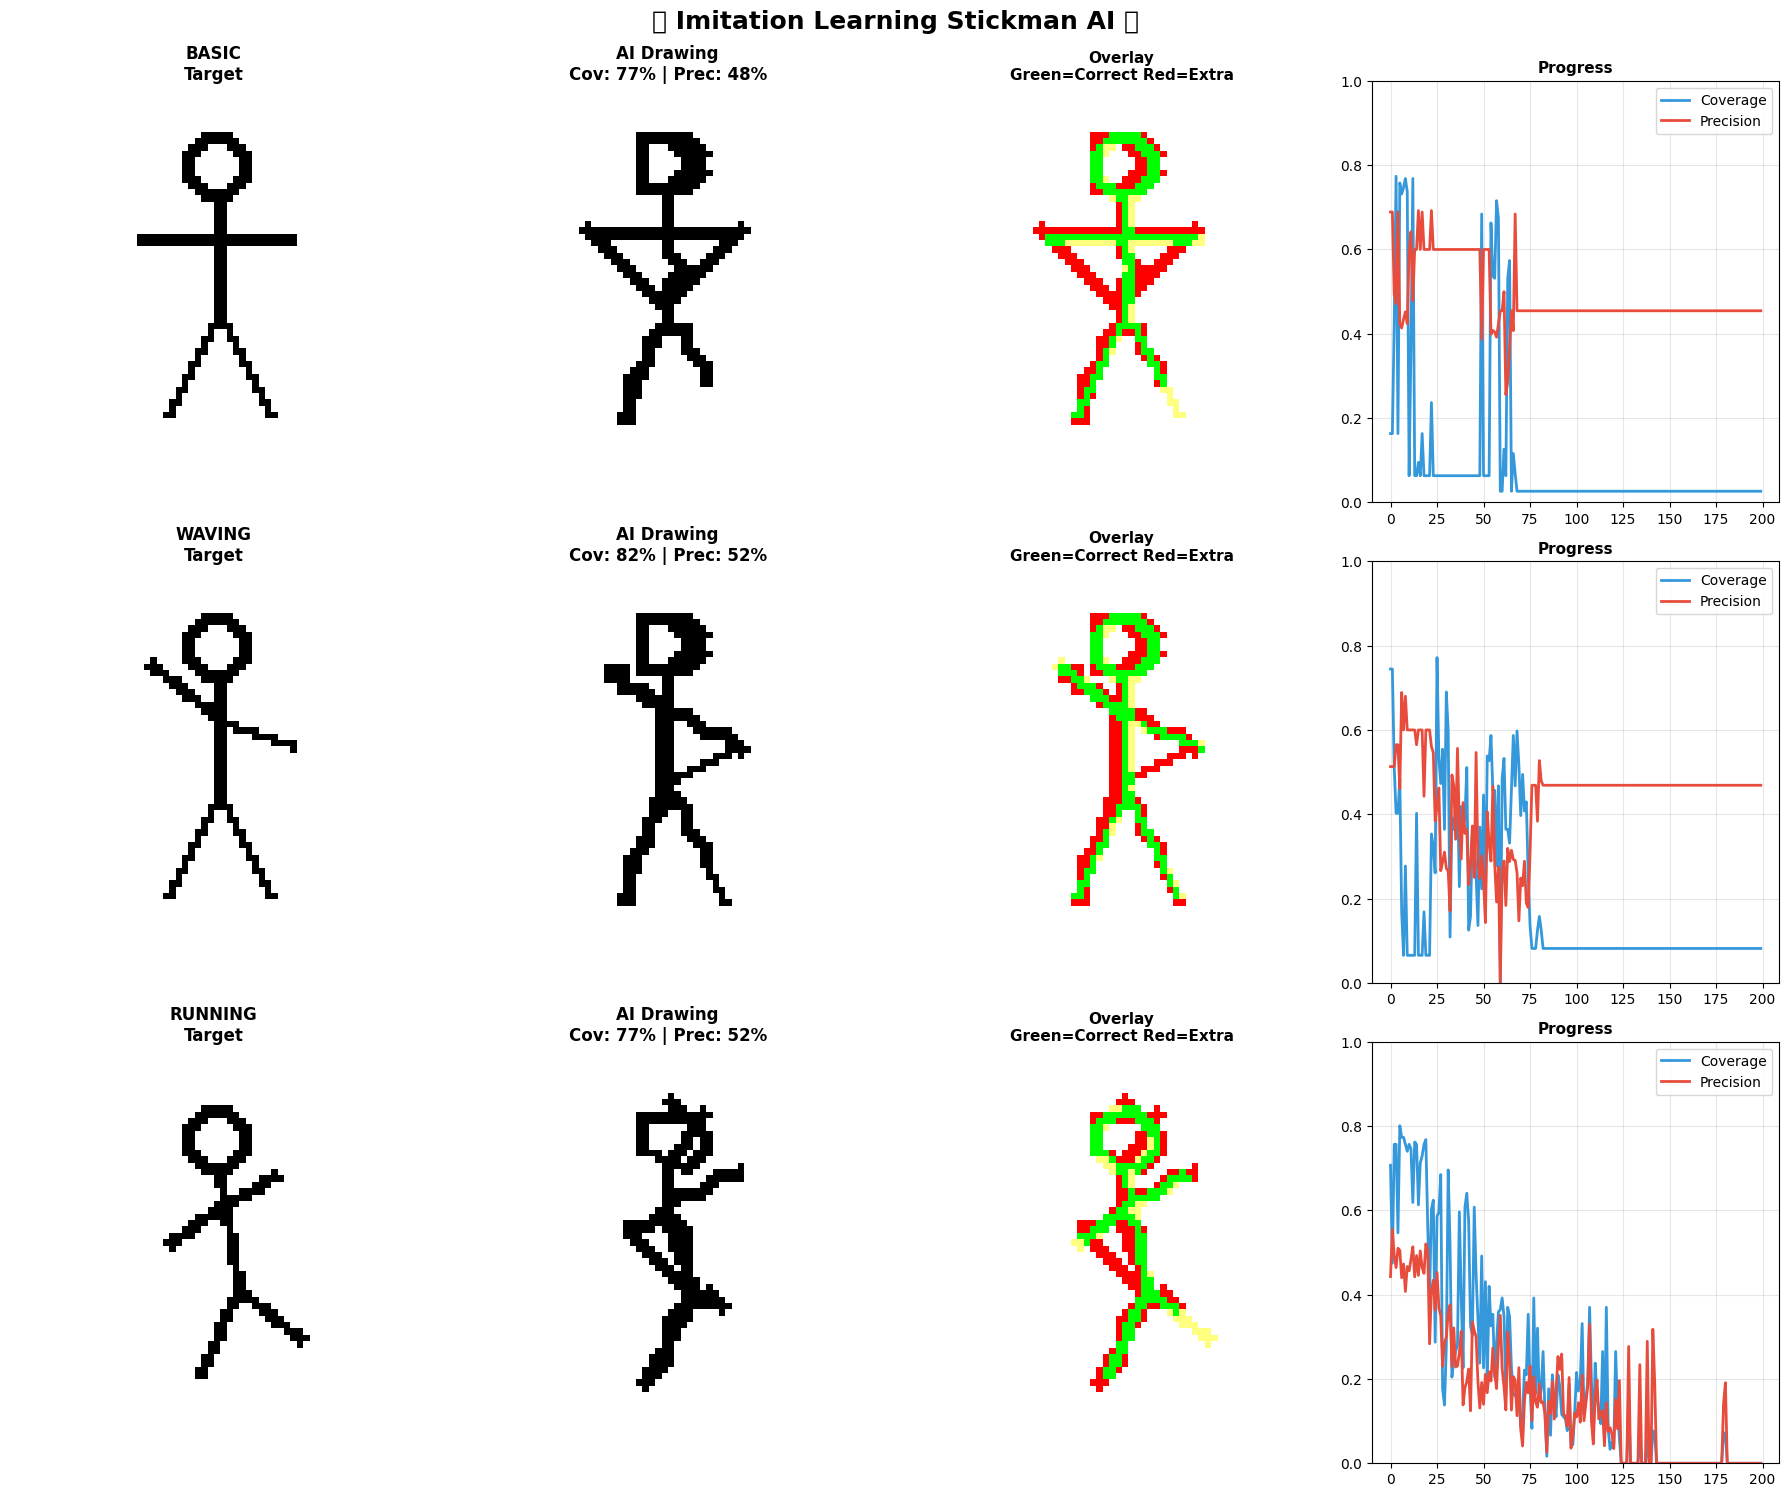

In [7]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw
import torch.nn.functional as F

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"🖥️  Using device: {device}")
if torch.cuda.is_available():
    print(f"   GPU: {torch.cuda.get_device_name(0)}")


class SmartStickmanEnv:
    """Environment with stroke-level rewards"""
    def __init__(self, canvas_size=64, grid_size=20):
        self.canvas_size = canvas_size
        self.grid_size = grid_size
        self.cell_size = canvas_size // grid_size
        self.target = None
        self.target_mask = None
        self.reset()

    def set_target(self, target):
        self.target = target
        self.target_mask = (target[:, :, 0] < 0.5) & (target[:, :, 1] < 0.5) & (target[:, :, 2] < 0.5)
        self.target_pixels = set(zip(*np.where(self.target_mask)))
        print(f"  🧍 Target has {len(self.target_pixels)} pixels")

    def reset(self):
        self.canvas = np.ones((self.canvas_size, self.canvas_size, 3), dtype=np.float32)
        self.cursor_grid_x = self.grid_size // 2
        self.cursor_grid_y = 2
        self.step_count = 0
        self.total_reward = 0
        return self.get_state()

    def get_state(self):
        state = np.zeros((self.canvas_size, self.canvas_size, 5), dtype=np.float32)
        state[:, :, :3] = self.canvas

        cx = self.cursor_grid_x * self.cell_size + self.cell_size // 2
        cy = self.cursor_grid_y * self.cell_size + self.cell_size // 2
        for dy in range(-3, 4):
            for dx in range(-3, 4):
                if dx*dx + dy*dy <= 9:
                    nx, ny = cx + dx, cy + dy
                    if 0 <= nx < self.canvas_size and 0 <= ny < self.canvas_size:
                        state[ny, nx, 3] = 1.0

        if self.target_mask is not None:
            state[:, :, 4] = self.target_mask.astype(np.float32)

        return state

    def grid_to_canvas(self, grid_x, grid_y):
        return grid_x * self.cell_size + self.cell_size // 2, grid_y * self.cell_size + self.cell_size // 2

    def get_line_pixels(self, x1, y1, x2, y2):
        """Get all pixels along a line"""
        pixels = []
        dx = abs(x2 - x1)
        dy = abs(y2 - y1)
        steps = max(dx, dy, 1)

        for i in range(steps + 1):
            t = i / steps
            x = int(x1 + (x2 - x1) * t)
            y = int(y1 + (y2 - y1) * t)
            # Add 2-pixel thickness
            for dy_off in range(-1, 2):
                for dx_off in range(-1, 2):
                    px, py = x + dx_off, y + dy_off
                    if 0 <= px < self.canvas_size and 0 <= py < self.canvas_size:
                        pixels.append((py, px))
        return set(pixels)

    def draw_stroke(self, x1, y1, x2, y2):
        img = Image.fromarray((self.canvas * 255).astype(np.uint8))
        draw = ImageDraw.Draw(img)
        draw.line([x1, y1, x2, y2], fill=(0, 0, 0), width=2)
        self.canvas = np.array(img).astype(np.float32) / 255.0

    def compute_metrics(self):
        canvas_mask = (self.canvas[:, :, 0] < 0.5) & (self.canvas[:, :, 1] < 0.5) & (self.canvas[:, :, 2] < 0.5)
        canvas_pixels = set(zip(*np.where(canvas_mask)))

        correct = len(canvas_pixels & self.target_pixels)
        extra = len(canvas_pixels - self.target_pixels)
        coverage = correct / max(1, len(self.target_pixels))
        precision = correct / max(1, len(canvas_pixels))

        return coverage, precision, correct, extra

    def step(self, action):
        prev_x, prev_y = self.grid_to_canvas(self.cursor_grid_x, self.cursor_grid_y)

        if action >= self.grid_size * self.grid_size:
            coverage, precision, correct, extra = self.compute_metrics()
            # Strong precision requirement for final reward
            final_reward = correct * 2 - extra * 3
            return self.get_state(), True, {
                'coverage': coverage,
                'precision': precision,
                'reward': final_reward
            }

        target_grid_x = action % self.grid_size
        target_grid_y = action // self.grid_size
        new_x, new_y = self.grid_to_canvas(target_grid_x, target_grid_y)

        # Evaluate stroke BEFORE drawing
        stroke_pixels = self.get_line_pixels(prev_x, prev_y, new_x, new_y)
        correct_in_stroke = len(stroke_pixels & self.target_pixels)
        extra_in_stroke = len(stroke_pixels - self.target_pixels)

        # STROKE-LEVEL REWARD: heavily favor strokes along target
        stroke_reward = correct_in_stroke * 3 - extra_in_stroke * 5

        # Draw the stroke
        self.draw_stroke(prev_x, prev_y, new_x, new_y)

        self.cursor_grid_x = target_grid_x
        self.cursor_grid_y = target_grid_y
        self.step_count += 1
        self.total_reward += stroke_reward

        coverage, precision, _, _ = self.compute_metrics()
        done = self.step_count >= 50  # Fewer steps = less scribbling

        return self.get_state(), done, {
            'coverage': coverage,
            'precision': precision,
            'reward': stroke_reward
        }


class StickmanExpert:
    """Expert demonstrator"""
    def __init__(self, canvas_size=64, grid_size=20, pose="basic"):
        self.canvas_size = canvas_size
        self.grid_size = grid_size
        self.cell_size = canvas_size // grid_size
        self.pose = pose

    def canvas_to_grid(self, x, y):
        grid_x = int(x / self.cell_size)
        grid_y = int(y / self.cell_size)
        return np.clip(grid_x, 0, self.grid_size - 1), np.clip(grid_y, 0, self.grid_size - 1)

    def draw_circle(self, center_x, center_y, radius, num_points=16):
        points = []
        for i in range(num_points):
            angle = 2 * np.pi * i / num_points
            x = center_x + radius * np.cos(angle)
            y = center_y + radius * np.sin(angle)
            points.append(self.canvas_to_grid(x, y))
        return points

    def draw_line(self, x1, y1, x2, y2, num_points=10):
        points = []
        for i in range(num_points):
            t = i / (num_points - 1)
            x = x1 + (x2 - x1) * t
            y = y1 + (y2 - y1) * t
            points.append(self.canvas_to_grid(x, y))
        return points

    def generate_basic_demo(self):
        center_x = self.canvas_size // 2
        trajectory = []

        head_y = 12
        trajectory.extend(self.draw_circle(center_x, head_y, 5, 12))

        body_top = head_y + 5
        body_bottom = body_top + 18
        trajectory.extend(self.draw_line(center_x, body_top, center_x, body_bottom, 8))

        shoulder_y = body_top + 6
        trajectory.extend(self.draw_line(center_x - 12, shoulder_y, center_x + 12, shoulder_y, 8))

        trajectory.extend(self.draw_line(center_x, body_bottom, center_x - 8, body_bottom + 16, 6))
        trajectory.extend(self.draw_line(center_x, body_bottom, center_x + 8, body_bottom + 16, 6))

        return trajectory

    def generate_waving_demo(self):
        center_x = self.canvas_size // 2
        trajectory = []

        head_y = 12
        trajectory.extend(self.draw_circle(center_x, head_y, 5, 12))

        body_top = head_y + 5
        body_bottom = body_top + 18
        trajectory.extend(self.draw_line(center_x, body_top, center_x, body_bottom, 8))

        shoulder_y = body_top + 6
        trajectory.extend(self.draw_line(center_x, shoulder_y, center_x - 10, shoulder_y - 8, 6))
        trajectory.extend(self.draw_line(center_x, shoulder_y, center_x + 12, shoulder_y + 4, 6))

        trajectory.extend(self.draw_line(center_x, body_bottom, center_x - 8, body_bottom + 16, 6))
        trajectory.extend(self.draw_line(center_x, body_bottom, center_x + 8, body_bottom + 16, 6))

        return trajectory

    def generate_running_demo(self):
        center_x = self.canvas_size // 2
        trajectory = []

        head_y = 14
        trajectory.extend(self.draw_circle(center_x, head_y, 5, 12))

        body_top = head_y + 5
        body_bottom_y = body_top + 18
        body_bottom_x = center_x + 3
        trajectory.extend(self.draw_line(center_x, body_top, body_bottom_x, body_bottom_y, 8))

        shoulder_y = body_top + 6
        trajectory.extend(self.draw_line(center_x, shoulder_y, center_x + 10, shoulder_y - 6, 6))
        trajectory.extend(self.draw_line(center_x, shoulder_y, center_x - 8, shoulder_y + 6, 6))

        trajectory.extend(self.draw_line(body_bottom_x, body_bottom_y, body_bottom_x - 6, body_bottom_y + 14, 6))
        trajectory.extend(self.draw_line(body_bottom_x, body_bottom_y, body_bottom_x + 10, body_bottom_y + 8, 6))

        return trajectory

    def add_noise_to_trajectory(self, trajectory, noise_level=0.3):
        """Add slight variations to demonstration"""
        noisy_traj = []
        for gx, gy in trajectory:
            if np.random.random() < noise_level:
                gx = np.clip(gx + np.random.randint(-1, 2), 0, self.grid_size - 1)
                gy = np.clip(gy + np.random.randint(-1, 2), 0, self.grid_size - 1)
            noisy_traj.append((gx, gy))
        return noisy_traj

    def _to_actions(self, trajectory):
        actions = [grid_y * self.grid_size + grid_x for grid_x, grid_y in trajectory]
        actions.append(self.grid_size * self.grid_size)
        return actions

    def generate_demonstration(self, add_noise=True):
        demos = {
            "basic": self.generate_basic_demo,
            "waving": self.generate_waving_demo,
            "running": self.generate_running_demo,
        }
        trajectory = demos[self.pose]()

        if add_noise:
            trajectory = self.add_noise_to_trajectory(trajectory, 0.2)

        return self._to_actions(trajectory)

    def generate_demonstrations(self, num_demos):
        print(f"  🧍 Generating {num_demos} expert demonstrations")
        all_demos = [self.generate_demonstration(add_noise=True) for _ in range(num_demos)]
        print(f"  ✓ Avg {np.mean([len(d) for d in all_demos]):.0f} strokes per demo")
        return all_demos


class StickmanNetwork(nn.Module):
    """Network for imitation learning"""
    def __init__(self, canvas_size=64, grid_size=20):
        super().__init__()
        self.grid_size = grid_size
        self.num_actions = grid_size * grid_size + 1

        self.conv1 = nn.Conv2d(5, 32, 3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, 3, stride=2, padding=1)
        self.conv3 = nn.Conv2d(64, 128, 3, stride=2, padding=1)
        self.conv4 = nn.Conv2d(128, 256, 3, stride=2, padding=1)

        flat_size = 256 * 8 * 8

        self.action_head = nn.Sequential(
            nn.Linear(flat_size, 512),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(512, self.num_actions)
        )

    def forward(self, state):
        if len(state.shape) == 3:
            state = state.unsqueeze(0)

        state = state.permute(0, 3, 1, 2)

        x = F.relu(self.conv1(state))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))

        features = x.flatten(1)
        action_logits = self.action_head(features)

        return action_logits


class ImitationTrainer:
    """Train via heavy imitation learning"""
    def __init__(self, target_image, pose_name, canvas_size=64, grid_size=20, device='cpu'):
        self.device = torch.device(device)
        self.env = SmartStickmanEnv(canvas_size, grid_size)
        self.policy = StickmanNetwork(canvas_size, grid_size).to(self.device)
        self.optimizer = optim.Adam(self.policy.parameters(), lr=5e-4)
        self.pose_name = pose_name

        self.target = target_image
        self.env.set_target(self.target)
        self.expert = StickmanExpert(canvas_size, grid_size, pose_name)

        self.best_coverage = 0.0
        self.best_precision = 0.0
        self.best_canvas = None
        self.coverage_history = []
        self.precision_history = []

    def collect_expert_data(self):
        """Collect demonstrations with state-action pairs"""
        demos = self.expert.generate_demonstrations(100)  # More demos
        states, actions = [], []

        for demo in demos:
            state = self.env.reset()
            for action in demo[:-1]:  # Exclude stop action
                states.append(state.copy())
                actions.append(action)
                state, _, _ = self.env.step(action)

        print(f"  ✓ Collected {len(states)} state-action pairs")
        return states, actions

    def train_imitation(self, states, actions, epochs=80, batch_size=128):
        """Heavy supervised learning phase"""
        print(f"\n📝 Imitation Learning Phase ({epochs} epochs)")
        print("="*70)

        dataset_size = len(states)
        best_test_acc = 0

        for epoch in range(epochs):
            indices = list(range(dataset_size))
            np.random.shuffle(indices)

            total_loss, correct, total = 0, 0, 0

            for i in range(0, dataset_size, batch_size):
                batch_idx = indices[i:i+batch_size]
                batch_states = torch.FloatTensor(np.array([states[idx] for idx in batch_idx])).to(self.device)
                batch_actions = torch.LongTensor(np.array([actions[idx] for idx in batch_idx])).to(self.device)

                action_logits = self.policy(batch_states)
                loss = F.cross_entropy(action_logits, batch_actions)

                self.optimizer.zero_grad()
                loss.backward()
                torch.nn.utils.clip_grad_norm_(self.policy.parameters(), 1.0)
                self.optimizer.step()

                # Track accuracy
                preds = torch.argmax(action_logits, dim=1)
                correct += (preds == batch_actions).sum().item()
                total += len(batch_actions)
                total_loss += loss.item()

            acc = correct / total
            avg_loss = total_loss / (dataset_size // batch_size)

            # Test on actual environment
            if epoch % 10 == 0 or epoch == epochs - 1:
                test_cov, test_prec = self.test_policy()
                print(f"  Epoch {epoch:3d} | Loss: {avg_loss:.4f} | Acc: {acc:.3f} | "
                      f"Test Cov: {test_cov:.1%} | Prec: {test_prec:.1%}")

                if test_cov > best_test_acc:
                    best_test_acc = test_cov

        print(f"✓ Imitation complete! Best test coverage: {best_test_acc:.1%}\n")

    def test_policy(self, deterministic=True):
        """Test current policy"""
        state = self.env.reset()
        done = False

        with torch.no_grad():
            while not done:
                state_tensor = torch.FloatTensor(state).to(self.device)
                action_logits = self.policy(state_tensor)

                if deterministic:
                    action = torch.argmax(action_logits).item()
                else:
                    action_dist = torch.distributions.Categorical(logits=action_logits)
                    action = action_dist.sample().item()

                state, done, info = self.env.step(action)

        coverage = info['coverage']
        precision = info['precision']

        if coverage > self.best_coverage or \
           (coverage >= self.best_coverage - 0.05 and precision > self.best_precision):
            self.best_coverage = coverage
            self.best_precision = precision
            self.best_canvas = self.env.canvas.copy()

        return coverage, precision

    def fine_tune_with_rl(self, episodes=200):
        """Optional: light RL fine-tuning"""
        print(f"🎨 Fine-tuning with RL ({episodes} episodes)")
        print("="*70)

        for episode in range(episodes):
            state = self.env.reset()
            done = False
            states, log_probs, rewards = [], [], []

            # Mostly exploit, little exploration
            epsilon = 0.1

            while not done:
                state_tensor = torch.FloatTensor(state).to(self.device)
                action_logits = self.policy(state_tensor)

                if np.random.random() < epsilon:
                    action_dist = torch.distributions.Categorical(logits=action_logits/0.5)
                    action = action_dist.sample()
                else:
                    action = torch.argmax(action_logits)

                action_dist = torch.distributions.Categorical(logits=action_logits)
                log_prob = action_dist.log_prob(action)

                next_state, done, info = self.env.step(action.item())
                reward = info['reward']

                states.append(state)
                log_probs.append(log_prob)
                rewards.append(reward)

                state = next_state

            # Simple REINFORCE update
            returns = []
            G = 0
            for r in reversed(rewards):
                G = r + 0.95 * G
                returns.insert(0, G)

            if len(returns) > 0:
                returns = torch.FloatTensor(returns).to(self.device)
                if len(returns) > 1:
                    returns = (returns - returns.mean()) / (returns.std() + 1e-8)

                policy_loss = 0
                for log_prob, ret in zip(log_probs, returns):
                    policy_loss = policy_loss - log_prob * ret

                policy_loss = policy_loss / len(log_probs)

                self.optimizer.zero_grad()
                policy_loss.backward()
                torch.nn.utils.clip_grad_norm_(self.policy.parameters(), 0.5)
                self.optimizer.step()

            # Track metrics
            coverage = info['coverage']
            precision = info['precision']
            self.coverage_history.append(coverage)
            self.precision_history.append(precision)

            if coverage > self.best_coverage or \
               (coverage >= self.best_coverage - 0.05 and precision > self.best_precision):
                self.best_coverage = coverage
                self.best_precision = precision
                self.best_canvas = self.env.canvas.copy()

            if episode % 50 == 0 or episode == episodes - 1:
                print(f"  Ep {episode:3d} | Cov: {coverage:.1%} | Prec: {precision:.1%} | "
                      f"Best: {self.best_coverage:.1%}/{self.best_precision:.1%}")

        print(f"✓ Fine-tuning complete!\n")

    def train(self):
        print("\n" + "="*70)
        print(f"TRAINING: {self.pose_name.upper()}")
        print("="*70)

        # Phase 1: Collect demos and train via imitation
        states, actions = self.collect_expert_data()
        self.train_imitation(states, actions, epochs=80)

        # Phase 2: Light RL fine-tuning
        self.fine_tune_with_rl(episodes=200)

        return self.best_canvas


class StickmanGenerator:
    @staticmethod
    def create_basic_stickman(canvas_size=64):
        img = Image.new('RGB', (canvas_size, canvas_size), 'white')
        draw = ImageDraw.Draw(img)
        center_x = canvas_size // 2

        head_y = 12
        head_radius = 5
        draw.ellipse([center_x - head_radius, head_y - head_radius,
                      center_x + head_radius, head_y + head_radius],
                     outline='black', width=2)

        body_top = head_y + head_radius
        body_bottom = body_top + 18
        draw.line([center_x, body_top, center_x, body_bottom], fill='black', width=2)

        shoulder_y = body_top + 6
        arm_span = 12
        draw.line([center_x - arm_span, shoulder_y, center_x + arm_span, shoulder_y],
                  fill='black', width=2)

        leg_bottom_y = body_bottom + 16
        leg_spread = 8
        draw.line([center_x, body_bottom, center_x - leg_spread, leg_bottom_y],
                  fill='black', width=2)
        draw.line([center_x, body_bottom, center_x + leg_spread, leg_bottom_y],
                  fill='black', width=2)

        return np.array(img).astype(np.float32) / 255.0, "Basic"

    @staticmethod
    def create_waving_stickman(canvas_size=64):
        img = Image.new('RGB', (canvas_size, canvas_size), 'white')
        draw = ImageDraw.Draw(img)
        center_x = canvas_size // 2

        head_y = 12
        head_radius = 5
        draw.ellipse([center_x - head_radius, head_y - head_radius,
                      center_x + head_radius, head_y + head_radius],
                     outline='black', width=2)

        body_top = head_y + head_radius
        body_bottom = body_top + 18
        draw.line([center_x, body_top, center_x, body_bottom], fill='black', width=2)

        shoulder_y = body_top + 6
        draw.line([center_x, shoulder_y, center_x - 10, shoulder_y - 8], fill='black', width=2)
        draw.line([center_x, shoulder_y, center_x + 12, shoulder_y + 4], fill='black', width=2)

        leg_bottom_y = body_bottom + 16
        leg_spread = 8
        draw.line([center_x, body_bottom, center_x - leg_spread, leg_bottom_y],
                  fill='black', width=2)
        draw.line([center_x, body_bottom, center_x + leg_spread, leg_bottom_y],
                  fill='black', width=2)

        return np.array(img).astype(np.float32) / 255.0, "Waving"

    @staticmethod
    def create_running_stickman(canvas_size=64):
        img = Image.new('RGB', (canvas_size, canvas_size), 'white')
        draw = ImageDraw.Draw(img)
        center_x = canvas_size // 2

        head_y = 14
        head_radius = 5
        draw.ellipse([center_x - head_radius, head_y - head_radius,
                      center_x + head_radius, head_y + head_radius],
                     outline='black', width=2)

        body_top = head_y + head_radius
        body_bottom_y = body_top + 18
        body_bottom_x = center_x + 3
        draw.line([center_x, body_top, body_bottom_x, body_bottom_y], fill='black', width=2)

        shoulder_y = body_top + 6
        draw.line([center_x, shoulder_y, center_x + 10, shoulder_y - 6], fill='black', width=2)
        draw.line([center_x, shoulder_y, center_x - 8, shoulder_y + 6], fill='black', width=2)

        draw.line([body_bottom_x, body_bottom_y, body_bottom_x - 6, body_bottom_y + 14],
                  fill='black', width=2)
        draw.line([body_bottom_x, body_bottom_y, body_bottom_x + 10, body_bottom_y + 8],
                  fill='black', width=2)

        return np.array(img).astype(np.float32) / 255.0, "Running"


def train_all_poses(canvas_size=64, grid_size=20, device='cpu'):
    poses = [
        ("basic", StickmanGenerator.create_basic_stickman),
        ("waving", StickmanGenerator.create_waving_stickman),
        ("running", StickmanGenerator.create_running_stickman),
    ]

    results = []

    for idx, (pose_name, pose_func) in enumerate(poses):
        print("\n" + "🧍"*35)
        print(f"POSE {idx+1}/{len(poses)}: {pose_name.upper()}")
        print("🧍"*35)

        target, _ = pose_func(canvas_size)
        trainer = ImitationTrainer(target, pose_name, canvas_size, grid_size, device)
        final_canvas = trainer.train()

        results.append({
            'name': pose_name,
            'target': target,
            'canvas': final_canvas,
            'coverage': trainer.best_coverage,
            'precision': trainer.best_precision,
            'coverage_history': trainer.coverage_history,
            'precision_history': trainer.precision_history
        })

    return results


def visualize_results(results):
    n = len(results)
    fig = plt.figure(figsize=(18, 5*n))

    for idx, r in enumerate(results):
        ax = plt.subplot(n, 4, idx*4 + 1)
        ax.imshow(r['target'])
        ax.set_title(f"{r['name'].upper()}\nTarget", fontsize=12, fontweight='bold')
        ax.axis('off')

        ax = plt.subplot(n, 4, idx*4 + 2)
        ax.imshow(r['canvas'])
        ax.set_title(f"AI Drawing\nCov: {r['coverage']:.0%} | Prec: {r['precision']:.0%}",
                    fontsize=12, fontweight='bold')
        ax.axis('off')

        ax = plt.subplot(n, 4, idx*4 + 3)
        overlay = r['canvas'].copy()
        target_mask = (r['target'][:, :, 0] < 0.5) & (r['target'][:, :, 1] < 0.5) & (r['target'][:, :, 2] < 0.5)
        canvas_mask = (r['canvas'][:, :, 0] < 0.5) & (r['canvas'][:, :, 1] < 0.5) & (r['canvas'][:, :, 2] < 0.5)

        overlay[target_mask & canvas_mask] = [0, 1, 0]
        overlay[canvas_mask & ~target_mask] = [1, 0, 0]
        overlay[target_mask & ~canvas_mask] = [1, 1, 0.5]

        ax.imshow(overlay)
        ax.set_title('Overlay\nGreen=Correct Red=Extra', fontsize=11, fontweight='bold')
        ax.axis('off')

        ax = plt.subplot(n, 4, idx*4 + 4)
        if r['coverage_history']:
            ax.plot(r['coverage_history'], label='Coverage', linewidth=2, color='#3498db')
            ax.plot(r['precision_history'], label='Precision', linewidth=2, color='#e74c3c')
            ax.set_title('Progress', fontsize=11, fontweight='bold')
            ax.set_ylim([0, 1])
            ax.legend()
            ax.grid(True, alpha=0.3)

    plt.suptitle("🧍 Imitation Learning Stickman AI 🧍",
                fontsize=18, y=0.995, fontweight='bold')
    plt.tight_layout()
    plt.savefig('/mnt/user-data/outputs/imitation_stickman_results.png', dpi=150, bbox_inches='tight')
    print(f"\n✅ Saved: /mnt/user-data/outputs/imitation_stickman_results.png")


if __name__ == "__main__":
    print("\n" + "="*70)
    print("🧍 IMITATION LEARNING STICKMAN AI 🧍")
    print("="*70)

    results = train_all_poses(canvas_size=64, grid_size=20, device=device)
    visualize_results(results)

    print("\n" + "="*70)
    print("✅ TRAINING COMPLETE!")
    print("="*70)
    print(f"{'Pose':15} {'Coverage':10} {'Precision':10}")
    print("-"*70)
    for r in results:
        print(f"{r['name'].upper():15} {r['coverage']:9.1%} {r['precision']:9.1%}")
    print("="*70 + "\n")

    plt.show()